## Advanced Lane Finding Project

Please find here all relevant code described in the write up
* [Camera calibration undistortion of image](#Calibration)
    * [Deliver calibration parameters (if pickle file exists)](#Calibration_Parameters)
    * [Compute calibration parameters and save them into a file](#Calibration_Compute)
    * [Test calibration](#Calibration_Test)
* [Color gradient transform](#ColorGradient)
    * [Analyze best values for gradients](#ColorGradient_Analyze)
    * [Test best values of gradient color  transform over all images](#ColorGradient_BestValuesOnAllImages)
* [Apply a perspective transform to rectify binary image ("birds-eye view")](#PerspectiveTransform)
    * [Test perspective transform](#PerspectiveTransform_Test)
* [Find lane pixel](#FindLanePixel)
    * [Test find lane pixel](#FindLanePixel_Test)
* [Determine the curvature of the lane and vehicle position with respect to center](#RadiusCurvature)
    * [Test radius of curvature](#TestRadiusCurvature)
* [Warp the detected lane boundaries back onto the original image](#BackToOriginalImage)
    * [Test green path](#TestGreenPath)
* [Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position](#PipelineOnVideo)

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Imports & definition of global variables

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import statistics
%matplotlib inline


camera_dir='camera_cal'
test_images = 'test_images'
camera_calibration_file = camera_dir + "/camera_calibration.p"
run_long_processes = False
want_crop = False
want_gray = False
ym_per_pix = 30.0/720 
xm_per_pix = 3.7/700

# Define a class to receive the characteristics of each line detection
class Line():
    
    def __init__(self, deep = 1):
        self.deep = deep
        # was the line detected in the last iteration?
        self.detected = True  
        # x values of the last n fits of the line
        self.recent_xfitted = None
        #average x values of the fitted line over the last n iterations
        self.bestx = np.array([])     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0, 0, 0])       
        #polynomial coefficients for thsete most recent fit
        self.current_fit =  None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None   
        #distance in meters of vehicle center from the line
        self.line_base_pos = None   
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        self.latest_line = np.array([])
        self.right_lane_pos = None
        self.left_lane_pos = None
        self.center = None
        self.size_between_lanes = None
        self.init_line_base_pos = None
    def outliers_indexes(self, values: []):
            """Use IQR to extract identify outliers in an array.
               Indexes of the array caontaining the outliers is returned.
               Why indexes ? This will be used to remove outliers of m and b which are separated arrays.
               For this we will unify the list of indexes returned for the 2 arrays.
            """
    
            #This is a copy
            dataset  = np.array(values)
            
            q1, q3= np.percentile(dataset,[25,75])
            iqr = q3 - q1
            lower_bound = q1 -(1.5 * iqr) 
            upper_bound = q3 +(1.5 * iqr) 
            
            #This is not a copy but a mittoring
            mirrored_dataset  = np.asarray(values)
            
            min_outliers = np.where(mirrored_dataset < lower_bound)
            max_outliers = np.where(mirrored_dataset > upper_bound)
            outliers = list(min_outliers[0])
            outliers.extend(max_outliers[0])
            return outliers
    # We will need to handle outliers of radius, mid positions, coefficients            
    def has_array_outliers(self, array_of_arrays, array):
        """Remove outliers for two related arrays of m and b"""
        check_index = np.array([0. for i in len(array_of_arrays) + 1])
        for index in range(len(array)):
            check_index[0] = array[index]
            for sub_index in len(array_of_arrays):
                check_index.append(array_of_arrays[sub_index][index])
            outliers = self.outliers_indexes(check_index)
            if len(outliers) > 0: return True
        return False
                
    # We will need to handle outliers of radius, mid positions, coefficients            
    def has_value_outliers(self, array, value):
        """Remove outliers for two related arrays of m and b"""
        if new_array is not None and value is not None:
            new_array = np.append(array, value)
            outliers = self.outliers_indexes(new_array)        
            return len(outliers) > 0       
        return False
            
    def set_geometry(self, center_car, left_lane_pos, right_lane_pos):
        self.center_car = center_car
        self.left_lane_pos = left_lane_pos
        self.right_lane_pos = right_lane_pos
        self.size_between_lanes = self.right_lane_pos - self.left_lane_pos
        min_center_car = 600
        max_center_car = 820
        return True, ""
        
    def check_lane_size(self, right_fitx, left_fitx):
        diff_bot = right_fitx[-1] - left_fitx[-1]
        offset = 0
        range_min = min(695, self.size_between_lanes - offset)
        range_max = max(870, self.size_between_lanes + offset)
        if diff_bot < range_min or diff_bot > range_max:
            print("ERROR: Size between lanes not correct: %d Ranges are (%d, %d)" % (diff_bot, range_min, range_max))
            return False, "ERROR: %d Ranges are (%d, %d)" % (diff_bot, range_min, range_max)
        return True, diff_bot
        

    def _cleanup(self, array):
        if(array is not None and len(array) > 0 and type(array[0]) is np.ndarray and self.deep < len(array)):
            array = array[len(array) - self.deep: ]
        #if array is not None: print("_cleanup after: array.shape:", array.shape)
        #else: print("_cleanup after: array.shape:", array)
        return array

    def add_fit(self, current_fit):
        if current_fit is None or len(current_fit) != 3:
            print("Error, trying to add a fit having not 3 values:", current_fit)
            self.detected = False
            return
        if self.current_fit is None: 
            self.current_fit = np.array([[0. for i in range(len(current_fit))]])
            self.current_fit[0] = current_fit
        else: 
            #if not self.has_array_outliers(self.current_fit, current_fit):
            self.current_fit = np.vstack((self.current_fit, current_fit))
        self.current_fit = self._cleanup(self.current_fit)

        #print("add_fit self.current_fit.shape:", self.current_fit.shape)
        
    def get_mean_fit(self):           
        if self.current_fit is not None and len(self.current_fit) > 0:
            self.best_fit = np.mean(self.current_fit, axis = 0)
            #self.best_fit = self.current_fit[-1]

        return self.best_fit
    
    def get_diff_fit(self):
        if len(self.best_fit > 1):
            return self.best_fit[-2] - self.best_fit[-1]
        
    def _check_allx(self, allx):
        offset = 150
        range_left_min = min(self.left_lane_pos - offset, 220)
        range_right_min = self.right_lane_pos - offset
        range_left_max = self.left_lane_pos + offset
        range_right_max = max(self.right_lane_pos + offset, 1200)
        if (allx[-1] > range_left_min and allx[-1] < range_left_max) or (allx[-1] > range_right_min and allx[-1] < range_right_max):            
            return True, ""
        return False, "ERROR:allx[-1]=%f,lr:(%f, %f),rr:(%f, %f)" % (allx[-1], range_left_min, range_left_max, range_right_min, range_right_max)
        
    def set_allx(self, allx):
        status, error = self._check_allx(allx)
        if status:
            self.allx = allx
            return True, ""
        self.detected = False
        return False, error
        
        
    def set_ally(self, ally):
        self.ally = ally
    
    def _check_radius_of_curvature(self, radius_of_curvature, ranges = (350, 3000), force: bool = False):
        min_curvature = ranges[0]
        max_curvature = ranges[1]
        if force or (radius_of_curvature > min_curvature and radius_of_curvature < max_curvature):           
            return True, ""
        return False, "ERROR: radius_of_curvature not saved because it is: %s (%s, %s)" % (radius_of_curvature, min_curvature, max_curvature)
        
    def set_radius_of_curvature(self, radius_of_curvature, ranges = (350, 3000), force: bool = False):
        status, error = self._check_radius_of_curvature(radius_of_curvature, ranges, force)
        if status:
            #if self.radius_of_curvature is  not None: print("shape self.radius_of_curvature before init/append", self.radius_of_curvature.shape)
            if self.radius_of_curvature is None: 
                self.radius_of_curvature = np.array([radius_of_curvature])
            else: 
                self.radius_of_curvature = np.append(self.radius_of_curvature, radius_of_curvature) 
            self.radius_of_curvature = self._cleanup(self.radius_of_curvature)
            #print("shape self.radius_of_curvature after cleanup ", self.radius_of_curvature.shape, self.radius_of_curvature)
            return True, ""
        self.detected = False
        
        return False, error 
    
    def _check_line_base_pos(self, line_base_pos, force: bool = False):
        if self.init_line_base_pos is None:
            self.init_line_base_pos = line_base_pos
            range_min = -800
            range_max = 800
        else:
            offset = 55
            range_min = - offset
            range_max = offset
        if force or (line_base_pos > range_min and line_base_pos < range_max):
            return True, "line_bas_pos: %s" % line_base_pos
        return False, "ERROR: line_base_pos not saved because it is: %f ranges (%f, %f)" % (line_base_pos, range_min, range_max)
        
    def set_line_base_pos(self, line_base_pos, force: bool = False):
        status, error = self._check_line_base_pos(line_base_pos, force)
        if status:
            #if self.line_base_pos is not None: print("shape self.line_base_pos before init/append ", self.line_base_pos.shape)
            if self.line_base_pos is None: 
                self.line_base_pos = np.array([line_base_pos])
            else: 
                self.line_base_pos = np.append(self.line_base_pos, line_base_pos) 
            self.line_base_pos = self._cleanup(self.line_base_pos)
            #print("shape self.line_base_pos after cleanup ", self.line_base_pos.shape, self.line_base_pos, statistics.mean(self.line_base_pos))

            return True, ""
        self.detected = False
        
        return False, error

    def get_radius_of_curvature(self):
        
        return statistics.mean(self.radius_of_curvature)
            
    def get_line_base_pos(self):

        return statistics.mean(self.line_base_pos)
            
    def add_x_fit_values(self, recent_xfitted):
        
        self.recent_xfitted = recent_xfitted

        #recent_xfitted = self._adapt_sizes_xfitted(recent_xfitted)
        #if self.recent_xfitted is None: 
        #    self.recent_xfitted = np.array([[0. for i in range(len(recent_xfitted))]])
        #    self.recent_xfitted[0] = recent_xfitted
        #    
        #else: 
        #    self.recent_xfitted = np.vstack((self.recent_xfitted, recent_xfitted))
        #    print("add_x_fit_values before clean_up: self.recent_xfitted.shape:", self.recent_xfitted.shape)
        #    
        #    
        #self.recent_xfitted = self._cleanup(self.recent_xfitted)
        #print("add_x_fit_values: self.recent_xfitted.shape:", self.recent_xfitted.shape)
            
                
    def _adapt_sizes_xfitted(self, recent_xfitted):
        if self.recent_xfitted is not None and len(self.recent_xfitted) > 0 and type(self.recent_xfitted[0]) is np.ndarray:
            # We need to be sure all array are the same length
            # If it is not the case extend length with the mean of the array
            if len(self.recent_xfitted[0]) > len(recent_xfitted):
                mean_val = statistics.mean(recent_xfitted)
                recent_xfitted = np.append(recent_xfitted, 
                                           [mean_val for i in range(len(self.recent_xfitted[0] - len(recent_xfitted)))])
                 
            elif (len(self.recent_xfitted[0]) < len(recent_xfitted)):
                new_recent_xfitted = None
                for elements in self.recent_xfitted:
                    mean_val = statistics.mean(elements)
                    elements = np.append([mean_val for i in range(len(recent_xfitted) - len(elements))])
                    if new_recent_xfitted is None: 
                        new_recent_xfitted = np.array([elements])
                    else: 
                        new_recent_xfitted = np.vstack(new_recent_xfitted, elements)
                self.recent_xfitted = new_recent_xfitted

        return recent_xfitted

                
    def get_mean_x_fit_values(self):

        #self.bestx = np.mean(self.recent_xfitted, axis = 0)
        self.bestx = self.recent_xfitted #self.recent_xfitted[-1]
        
        return self.bestx
    def is_value_outlier_and_cleanup(self, array, value, force_clean = True):
        if array is not None and value is not None:
            new_array = np.append(array, value)  
            outlier_indexes = self.outliers_indexes(new_array)   
            if len(outlier_indexes) > 0:
                if outlier_indexes[-1] == len(new_array) - 1:
                    return False
                if force_clean:
                    outlier_indexes = np.unique(outlier_indexes)[::-1]
                    for index in outlier_indexes:    
                        if index < len(array): array = np.delete(array, index)
        return True
                
    def check_distances(self, right_fitx_new, left_fitx_new):
        diff_bot = right_fitx_new[-1] - left_fitx_new[-1]
        if diff_bot < 780 or diff_bot > 900:
            print("Error: diff_bot:", diff_bot)
            return False
        return True
        
                    
    def line_detected(self):
        return self.detected

        
        
        
def add_new_line_if_not_outlier(deepness_line: Line, new_line: Line):
    
    if not new_line.detected:
        deepness_line.detected = False
        error = "Error: add_new_line_if_not_outlier: Line not detected"
        return False, error

    deepness_line.detected = True

    #deepness_line.latest_line = np.append(deepness_line.latest_line, new_line)
    #if len(deepness_line.latest_line) > deepness_line.deep:
    #    deepness_line.radius_of_curvature = np.array([line.radius_of_curvature[-1] for line in deepness_line.latest_line])
    #    deepness_line.line_base_pos = np.array([line.line_base_pos[-1] for line in deepness_line.latest_line])
    #    deepness_line.recent_xfitted = np.array([line.recent_xfitted[-1] for line in deepness_line.latest_line])
    #    deepness_line.current_fit = np.array([line.current_fit[-1] for line in deepness_line.latest_line])
    #    deepness_line.latest_line = np.array([])
        
    #if not deepness_line.is_value_outlier_and_cleanup(deepness_line.radius_of_curvature, new_line.radius_of_curvature[0], False):
    #    print("radius_of_curvature Out lier for deepness_line: ", deepness_line.radius_of_curvature, new_line.radius_of_curvature[0])
    #    deepness_line.detected = len(deepness_line.radius_of_curvature) > 0            
    #    return deepness_line.detected
    #
    #if not deepness_line.is_value_outlier_and_cleanup(deepness_line.line_base_pos, new_line.line_base_pos[0], False):
    #    print("line_base_pos Out lier for deepness_line: ", deepness_line.line_base_pos, new_line.line_base_pos[0])
    #    deepness_line.detected = len(deepness_line.line_base_pos) > 0            
    #    return deepness_line.detected
    

    errors = ""
#    print("add_new_line_if_not_outlier: set_radius_of_curvature with first element of ", new_line.radius_of_curvature)
    status_curv, error_curv = deepness_line._check_radius_of_curvature(new_line.radius_of_curvature[0], (200, 80000), deepness_line.radius_of_curvature is None)
    status_base, error_base = deepness_line._check_line_base_pos(new_line.line_base_pos[0], deepness_line.line_base_pos is None)
    if status_curv and status_base:
        _, error = deepness_line.set_radius_of_curvature(new_line.radius_of_curvature[0], (200, 80000), deepness_line.radius_of_curvature is None)
        errors += error
        _, error = deepness_line.set_line_base_pos(new_line.line_base_pos[0], deepness_line.line_base_pos is None)
        errors += error
        _, error = deepness_line.set_allx(new_line.allx)
        errors += error
        deepness_line.set_ally(new_line.ally)
        deepness_line.add_x_fit_values(new_line.get_mean_x_fit_values())
        deepness_line.add_fit(new_line.current_fit[0])
        deepness_line.detected = True

    else:
        errors = error_curv + error_base
        deepness_line.detected = False

    return  deepness_line.detected, errors


            

# Initial creation will be reseted prior video analysis        
left_line = Line()
right_line = Line()

## Camera calibration undistortion of image <A name='Calibration'/>

### Deliver calibration parameters (if pickle file exists) <A name='Calibration_Parameters'>

In [2]:

#reads the calibrated values 
def get_camera_calibration():
    camera_calibration = pickle.load( open(camera_calibration_file, "rb" ) )
    return camera_calibration["mtx"], camera_calibration["dist"]

### Compute calibration parameters and save them into a file <A name='Calibration_Compute'>

In [3]:
def prepare_calibration(glob_names = camera_dir + '/calibration*.jpg'):
    
    nx = 6
    ny = 9
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny,0:nx].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob(glob_names)
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (ny,nx),None)
    
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints               


In [4]:
import os

def calculate_undistort(img, glob_names = camera_dir + '/calibration*.jpg'):
    
    objpoints, imgpoints = prepare_calibration(glob_names)
    
    # Do camera calibration given object points and image points

    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    # When camera is calibrated save calibration file
    output = open(camera_calibration_file, 'wb')
    camera_calibration = {'mtx': mtx, 'dist': dist}
    pickle.dump(camera_calibration, output)
    output.close()

def undistort(img, glob_names = camera_dir + '/calibration*.jpg'):

    
    if not os.path.exists(camera_calibration_file):
        calculate_undistort(img, glob_names)
        
    mtx, dist = get_camera_calibration()        
    dst = cv2.undistort(img, mtx, dist, None, mtx) 
    
    return dst
    

### Test calibration  <A name='Calibration_Test'>

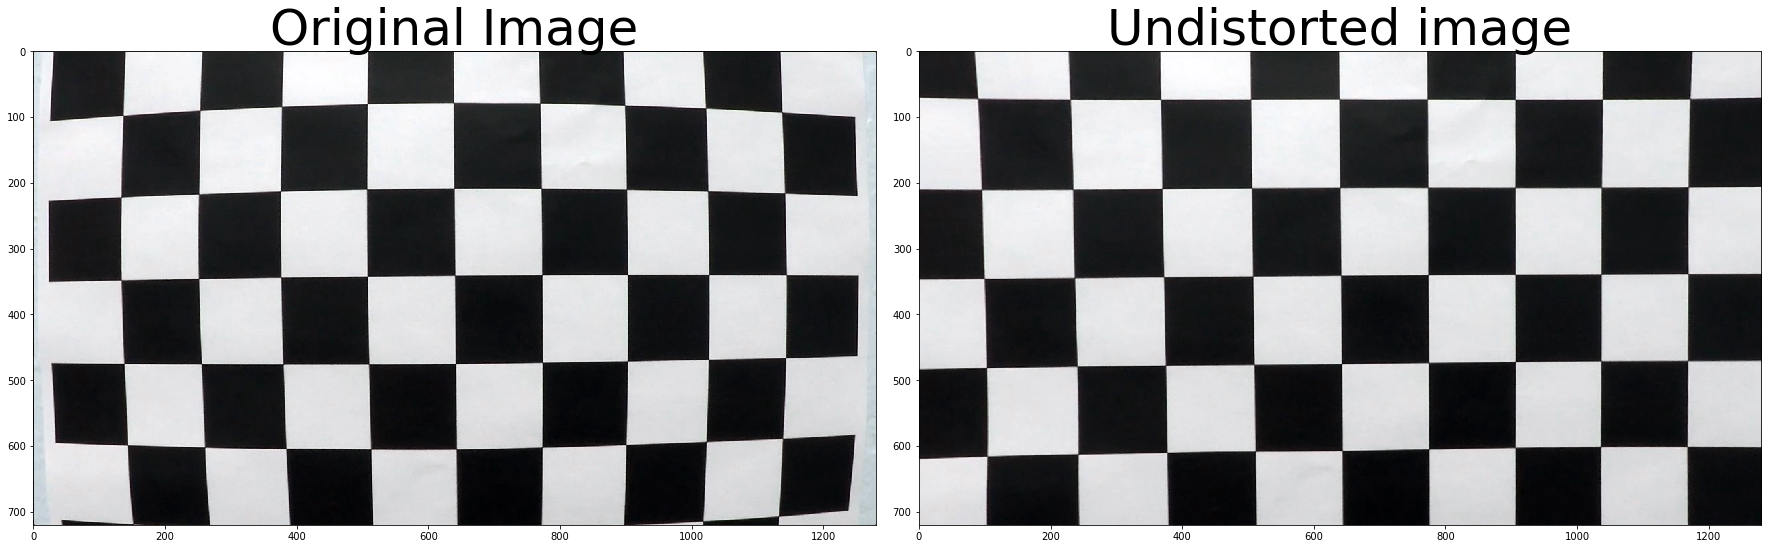

In [5]:
# Test undistortion on an image
img = cv2.imread(camera_dir + "/calibration1.jpg")

dst = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

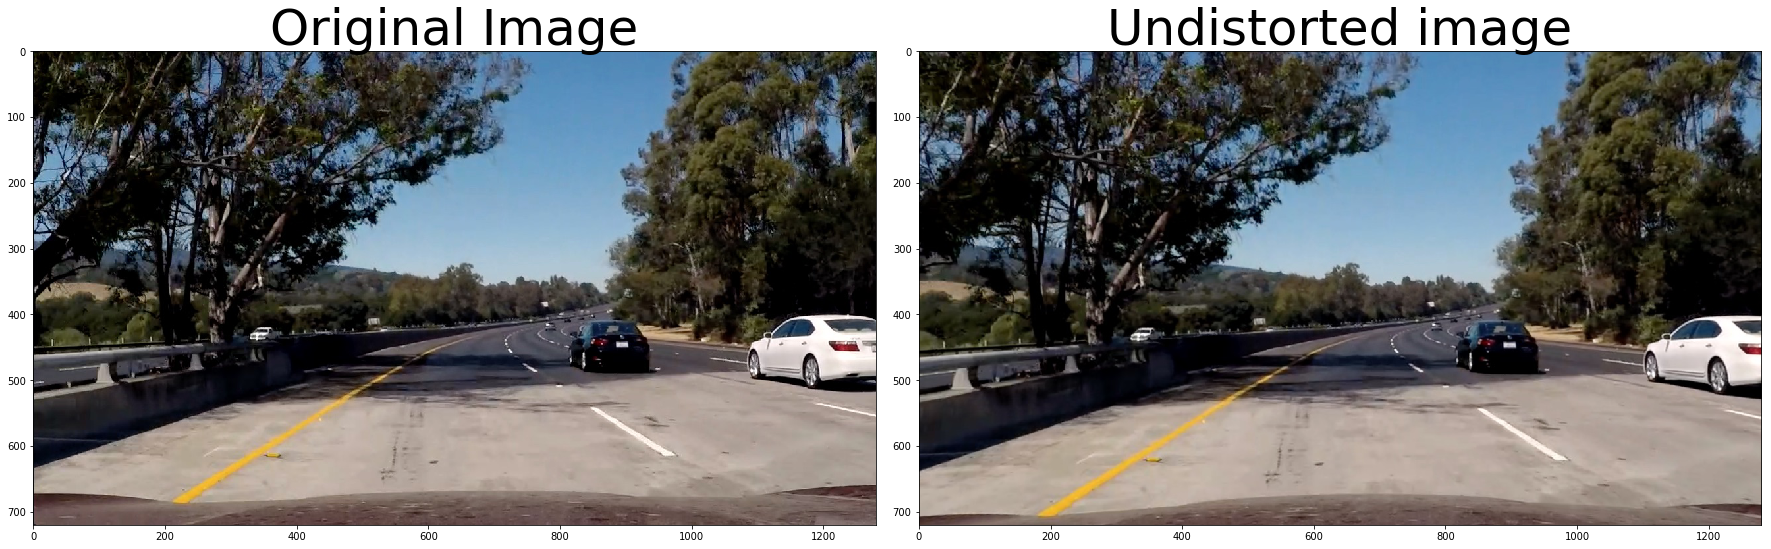

In [6]:
distorted_image = cv2.cvtColor(cv2.imread(test_images + '/test5.jpg'), cv2.COLOR_BGR2RGB)
img = undistort(distorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img, cmap='gray')
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply on region of interest on the image
I could observe that the image on the video have some dark lines on the left side that are influencing the poly fit. For this reason I am croping out all but the region of interest.

In [7]:
import colorsys
def cropin_region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    
    imshape = img.shape

    
    x_offset_high = imshape[1] / 15
    x_offset_low_right = imshape[1] - imshape[1] / 15
    x_offset_low_left = imshape[1] / 9
    y_offset_low =  imshape[0] - imshape[0] / 10
    
    #vertices = np.array([[(x_offset_low,                   imshape[0]),
    #                      (imshape[1] / 2 - x_offset_high, 3 * imshape[0] / 5), 
    #                      (imshape[1] / 2 + x_offset_high, 3 * imshape[0] / 5), 
    #                      (imshape[1] - x_offset_low,      imshape[0])]], dtype=np.int32)
    #
    whole_page = np.array([[(0                             , 0),
                            (imshape[1]                    , 0), 
                            (imshape[1]                    , y_offset_low), 
                            (x_offset_low_right            , y_offset_low), 
                            (imshape[1] / 2 + x_offset_high, 3 * imshape[0] / 5), 
                            (imshape[1] / 2 - x_offset_high, 3 * imshape[0] / 5), 
                            (x_offset_low_left,              y_offset_low),
                            (0,                              y_offset_low)
                           ]], dtype=np.int32)
    mask_color = colorsys.hls_to_rgb(255, 0, 255)
    cropped = np.copy(img)
    
        
    ##filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(cropped, whole_page, mask_color)
    #
    ##returning the image only where mask pixels are nonzero
    #masked_image = cv2.bitwise_and(img, mask)
    
    return cropped
    

## Color gradient transform <A name='ColorGradient'>

In [8]:
def hls_select(img, thresh=(50, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    H = hls[:,:,0]

    return L, cv2.inRange(hls, (0, 0, thresh[0]), (30, 192, thresh[1]))

def remove_black(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel = np.array([[-1,-1,-1], [-1,1,-1], [-1,-1,-1]])
    dot_mask = cv2.filter2D(thresh, -1, kernel)
    
    result = cv2.bitwise_xor(thresh, dot_mask)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    dilate = cv2.dilate(result, kernel, iterations=1)
    result = cv2.bitwise_and(image, image, mask=dilate)
    result[dilate==0] = [255,255,255]
    
    return result

def abs_sobel_threshold(sobel, s_channel_thresholded, thresh = (0, 255)):
             
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) 
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sxbinary
       

def mag_threshold(sobelx, sobely, s_channel_thresholded, mag_thresh=(0, 255)):
    
    gradmag = np.sqrt(sobelx**2+ sobely**2)

    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    sxbinary = np.zeros_like(gradmag)
    sxbinary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return sxbinary


def dir_threshold(sobelx, sobely, s_channel_thresholded, thresh=(0, np.pi/2)):  
    
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)

    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    
    return sxbinary

def combine(image_orig, sobel_kernel=3, abs_thresh = (0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2), hls_thresh = (0, 255)):
    l_channel, s_channel_thresholded = hls_select(image_orig, hls_thresh)
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)       

    if want_gray:
        gray = cv2.cvtColor(image_orig, cv2.COLOR_RGB2GRAY)
    
        image0 = abs_sobel_threshold(sobelx, gray, abs_thresh)
        image2 = mag_threshold(sobelx, sobely, gray, mag_thresh)
        image3 = dir_threshold(sobelx, sobely, gray, dir_thresh)
    else:
        image0 = abs_sobel_threshold(sobelx, s_channel_thresholded, abs_thresh)
        image2 = mag_threshold(sobelx, sobely, s_channel_thresholded, mag_thresh)
        image3 = dir_threshold(sobelx, sobely, s_channel_thresholded, dir_thresh)
        
      
    combined = np.zeros_like(image0)
    combined[(image0 == 1) | ((image2 == 1) & (image3 == 1))| (s_channel_thresholded == 1)] = 1
    
    return combined



### Analyze best values for gradients <A name='ColorGradient_Analyze'>

In [9]:
def test_image(image_name):
    image_distorted = cv2.imread(image_name)
    
    image = undistort(image_distorted)
    
    f, axs = plt.subplots(1, 1, figsize=(24, 9))
    f.tight_layout()
    axs.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs.set_title('Original Image ' + image_name, fontsize=20)

    for ksize in [5, 7, 9]: 
        for abs_var in [30]:
            for mag_var in [30]:
                for angle in [50, 90]:
                    for color in [100, 90, 110]:
                
                        title = []
                        combined = []
        
                        # Apply each of the thresholding functions
                        abs_thresh = (abs_var, 255 - abs_var)
                        mag_thresh=(mag_var , 255 - mag_var)
                        dir_thresh = (0 + angle * np.pi / 180.0, np.pi/2 -  angle * np.pi / 180.0)                
                        color_thresh = (0, 255 - color)
                        combined.append(combine(image, ksize, abs_thresh, mag_thresh, dir_thresh, color_thresh))
                        title.append("ksize:%d,abs:%d,mag:%d,angle:%d,col:%d\nabs:%s,mag:%s,dir:%s,col:%s" % (ksize, abs_var, mag_var, angle, color, abs_thresh, mag_thresh, (int(dir_thresh[0] * 180 / np.pi), int(dir_thresh[1] * 180 / np.pi)), color_thresh))
                
                        abs_thresh = (abs_var , 255)
                        mag_thresh=(mag_var , 255)
                        dir_thresh = (0 + angle * np.pi / 180.0, np.pi/2 -  angle * np.pi / 180.0)
                        color_thresh = (0, 255 - color)
                        combined.append(combine(image, ksize, abs_thresh, mag_thresh, dir_thresh, color_thresh))
                        title.append("ksize:%d,abs:%d,mag:%d,angle:%d,col:%d\nabs:%s,mag:%s,dir:%s,col:%s" % (ksize, abs_var, mag_var, angle, color, abs_thresh, mag_thresh, (int(dir_thresh[0] * 180 / np.pi), int(dir_thresh[1] * 180 / np.pi)), color_thresh))
        
                        abs_thresh = (abs_var, 255 - abs_var)
                        mag_thresh=(mag_var , 255 - mag_var)
                        dir_thresh = (0 + angle * np.pi / 180.0, np.pi/2)
                        color_thresh = (0, 255 - color)
                        combined.append(combine(image, ksize, abs_thresh, mag_thresh, dir_thresh, color_thresh))
                        title.append("ksize:%d,abs:%d,mag:%d,angle:%d,col:%d\nabs:%s,mag:%s,dir:%s,col:%s" % (ksize, abs_var, mag_var, angle, color, abs_thresh, mag_thresh, (int(dir_thresh[0] * 180 / np.pi), int(dir_thresh[1] * 180 / np.pi)), color_thresh))
        
                        f, axs = plt.subplots(1, 3, figsize=(24, 9))
                        plt.figure()
                        f.tight_layout()
                        for index in range(len(axs)):
                            axs[index].imshow(combined[index], cmap = 'gray')
                            axs[index].set_title(title[index], fontsize=20)


          

In [10]:
if run_long_processes: test_image(test_images + "/straight_lines1.jpg")           

In [11]:
if run_long_processes: test_image(test_images + "/straight_lines2.jpg")           

In [12]:
if run_long_processes: test_image(test_images + "/test1.jpg") 

In [13]:
if run_long_processes: test_image(test_images + "/test5.jpg") 

In [14]:
def combined_best_params(undistorted_image, ksize = 9, abs_thresh = (30, 255 - 30), mag_thresh=(30 , 255 - 30), dir_thresh = (0, np.pi / 2),  color_thresh = (50, 255)):
    
    combined = combine(undistorted_image, ksize, abs_thresh, mag_thresh, dir_thresh, color_thresh)
    
    return combined
        

### Test best values of gradient color  transform over all images <A name='ColorGradient_BestValuesOnAllImages'>

In [15]:
def test_narrowed_image(image_name):
    image_bgr = cv2.imread(image_name)
    
    distorted_image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image = undistort(distorted_image_rgb)
    ksize = 9
    abs_var = 30
    mag_var = 30
    angle = 90       
    color = 50
    
    abs_thresh = (abs_var, 255 - abs_var)
    mag_thresh = (mag_var , 255 - mag_var)
    dir_thresh = (0 + angle * np.pi / 180.0, np.pi/2 -  angle * np.pi / 180.0)                
    color_thresh = (color, 255)

    
    title = []
    combined = []
    combined.append(image)
    title.append('Original Image ' + image_name)


    combined.append(combined_best_params(image, ksize, abs_thresh, mag_thresh, dir_thresh, color_thresh))  
    title.append("ksize:%d,abs:%d,mag:%d,angle:%d,col:%d\nabs:%s,mag:%s,dir:%s,col:%s" % (ksize, abs_var, mag_var, angle, color, abs_thresh, mag_thresh, (int(dir_thresh[0] * 180 / np.pi), int(dir_thresh[1] * 180 / np.pi)), color_thresh))
    
   
    f, axs = plt.subplots(1, 2, figsize=(24, 9))
    plt.figure()
    f.tight_layout()
    for index in range(len(axs)):
        if index > 0:
            axs[index].imshow(combined[index], cmap = 'gray')
        else:
            axs[index].imshow(combined[index])
            
        axs[index].set_title(title[index], fontsize=20)

if run_long_processes:
    images = glob.glob(test_images + '/*')
    for image in images:
        test_narrowed_image(image)


## Apply a perspective transform to rectify binary image ("birds-eye view") <A name='PerspectiveTransform'>

In [16]:
def perspective_transform(undistorted_img, nx = 9, ny = 5):
    
    img_size = (undistorted_img.shape[1], undistorted_img.shape[0])
    
    imshape = undistorted_img.shape
    
    dst_min_x = 100
    dst_max_x = 1100
    src = np.float32([ [242, 670],       [1050, 670],      [712, 463],      [574, 463] ])
    dst = np.float32([ [dst_min_x, 683], [dst_max_x, 683], [dst_max_x, 10], [dst_min_x, 10]  ])
       
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(undistorted_img, M, img_size, flags = cv2.INTER_LINEAR)

    return warped, M, Minv


### Test perspective transform <A name='PerspectiveTransform_Test'>

In [17]:
def test_perspective_transform(image_name):
    image_bgr = cv2.imread(image_name)
    distorted_image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    undistorted_img = undistort(distorted_image_rgb)
    warped, M, Minv = perspective_transform(undistorted_img)
    
    f, (ax1, ax3) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undistorted_img)
    ax1.set_title('Undistorted imaged', fontsize=20)
    ax3.imshow(warped)
    ax3.set_title('Perspective transformed imaged', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


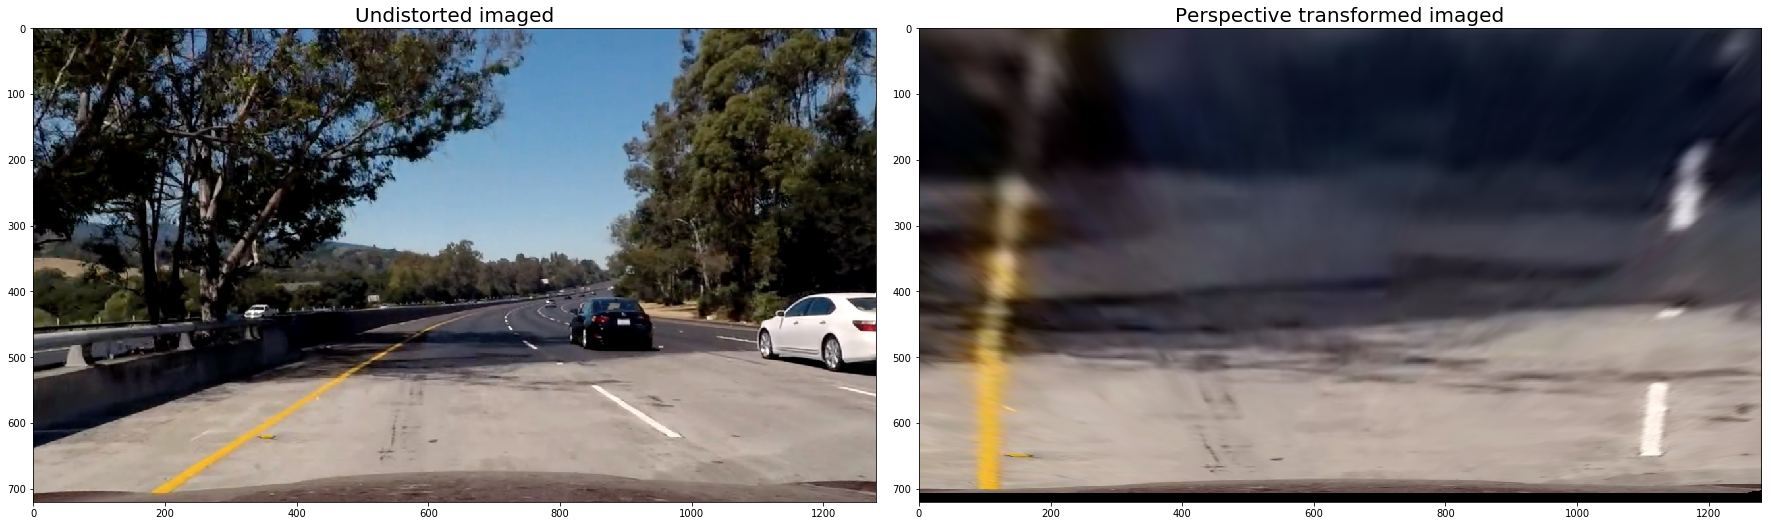

In [18]:
images = glob.glob(test_images + '/*')
for image in images:
    test_perspective_transform(image)
    if not run_long_processes: break

        
    


## Find lane pixel<A name='FindLanePixel'>

In [19]:
def find_lane_pixels(binary_warped, debug: bool):
    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Set the width of the windows +/- margin
    margin = 100
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    point_left = np.int(histogram.shape[0] // 2 - margin)
    point_right = np.int(histogram.shape[0] // 2 + margin)
    leftx_base = np.argmax(histogram[:point_left])
    rightx_base = np.argmax(histogram[point_right:]) + point_right

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    bottom_window = binary_warped.shape[0] - 30
    window_height = np.int(bottom_window//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    prev_leftx_current = leftx_current
    prev_rightx_current = rightx_current

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bottom_window - (window+1)*window_height
        win_y_high = bottom_window - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &  (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        
        # If you found > minpix pixels, recenter next window on their mean position

        if len(good_left_inds) > minpix:
            prev_leftx_current = leftx_current
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            left_lane_inds.append(good_left_inds)
            
        if len(good_right_inds) > minpix:        
            prev_rightx_current = rightx_current            
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            right_lane_inds.append(good_right_inds)
                                   

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(leftx, lefty, rightx, righty, out_img, use_meters: bool, debug: bool):
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    if use_meters:
        leftx = leftx * xm_per_pix
        lefty = lefty * ym_per_pix
        rightx = rightx * xm_per_pix
        righty = righty * ym_per_pix
        ploty = ploty * ym_per_pix
        debug = False

    
    if len(lefty) > 0:  
        left_fit = np.polyfit(lefty, leftx, 2) 
    else: 
        left_fit = None
        
    if len(righty) > 0: 
        right_fit = np.polyfit(righty, rightx, 2) 
    else: 
        right_fit = None

       
    
    if debug:
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
    
    return out_img, ploty, left_fit, right_fit





### Test find lane pixel <A name='FindLanePixel_Test'>

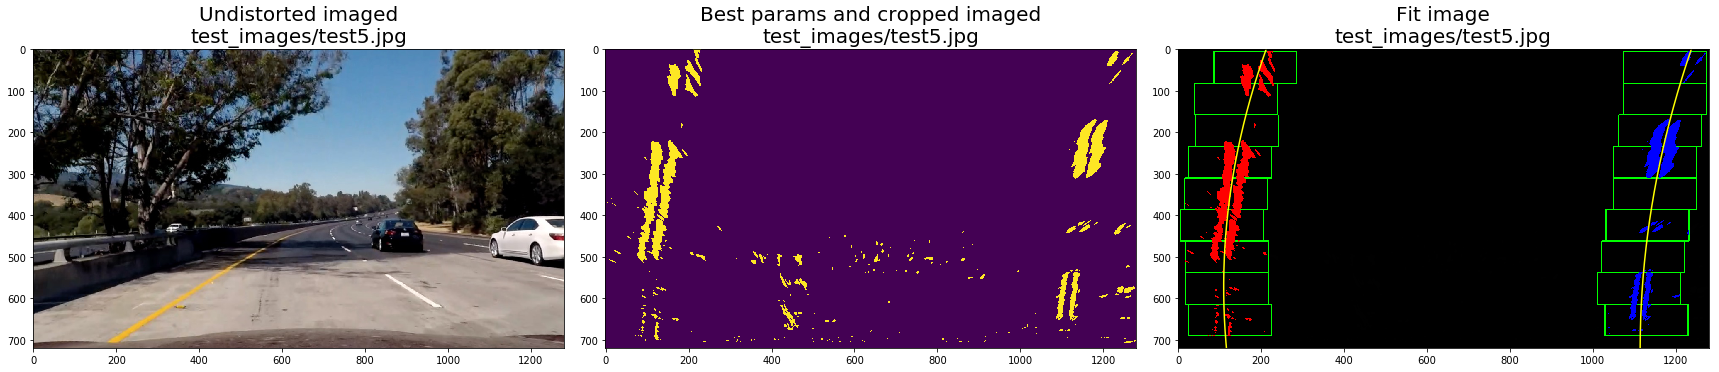

In [20]:
def image_to_polynomial(undistorted_image, left_line, right_line, debug: bool = False, image_name: str = ""):    
    warped, M, Minv = perspective_transform(undistorted_img)
    binary_warped = combined_best_params(warped)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, debug)
    out_img, ploty, left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty, out_img, False, True)
    
    if debug:
            # Generate x and y values for plotting
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions


        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(undistorted_img)
        ax1.set_title('Undistorted imaged\n' + image_name, fontsize=20)
        ax2.imshow(binary_warped)
        ax2.set_title('Best params and cropped imaged\n' + image_name, fontsize=20)
        
        ax3.imshow(out_img)
        ax3.set_title('Fit image\n' + image_name, fontsize=20)
        ax3.plot(left_fitx, ploty, color='yellow')
        ax3.plot(right_fitx, ploty, color='yellow')

images = glob.glob(test_images + '/*')
for image in images:
    left_line = Line()
    right_line = Line()
    image_bgr = cv2.imread(image)
    distorted_image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    undistorted_img = undistort(distorted_image_rgb)
    image_to_polynomial(undistorted_img, left_line, right_line, True, image)
    if not run_long_processes: break



## Determine the curvature of the lane and vehicle position with respect to center<A name = "RadiusCurvature">


In [21]:


def measure_curvature_meters(leftx, lefty, rightx, righty, out_img, want_meters: bool, index = -1):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    out_image, ploty, left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty, out_img, want_meters, False)
    y_eval = ploty[index]
    
    # Calculation of R_curve (radius of curvature)    
    left_curverad =  ((1 + (2*left_fit[0] * y_eval + left_fit[1] )**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]* y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
            
    return (left_curverad, right_curverad)



### Test radius of curvature <A Name = "TestRadiusCurvature">

In [22]:
images = glob.glob(test_images + '/*')
for image in images:
    image_bgr = cv2.imread(image)
    distorted_image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    undistorted_img = undistort(distorted_image_rgb)
    if want_crop:
        cropped = cropin_region_of_interest(undistorted_img)
        warped, M, Minv = perspective_transform(cropped)    
    else:
        warped, M, Minv = perspective_transform(undistorted_img)    

    binary_warped = combined_best_params(warped)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, False)
    (left_curverad, right_curverad) = measure_curvature_meters(leftx, lefty, rightx, righty, out_img, True)
    print("Image: %s, curvature: %f m" % (image, (left_curverad + right_curverad)  / 2))

Image: test_images/test5.jpg, curvature: 612.917353 m
Image: test_images/test6.jpg, curvature: 3126.172337 m
Image: test_images/straight_lines2.jpg, curvature: 13930.313901 m
Image: test_images/straight_lines1.jpg, curvature: 14106.661785 m
Image: test_images/test3.jpg, curvature: 1500.485561 m
Image: test_images/test4.jpg, curvature: 484.221080 m
Image: test_images/test1.jpg, curvature: 1340.649505 m
Image: test_images/test2.jpg, curvature: 404.787499 m


## Warp the detected lane boundaries back onto the original image <A name = "BackToOriginalImage">

In [23]:
def create_green_path(image_bgr, cur_left_line, cur_right_line, debug = False, print_debug_details = False):
    
    left_line = Line(1)
    right_line = Line(1)
    
    distorted_image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    undistorted_img = undistort(distorted_image_rgb)
    if want_crop:
        cropped = cropin_region_of_interest(undistorted_img)
        warped, M, Minv = perspective_transform(cropped)    
    else:
        warped, M, Minv = perspective_transform(undistorted_img)    
        
    binary_warped = combined_best_params(warped)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, print_debug_details)
    
    out_image, ploty, left_fit_new, right_fit_new = fit_polynomial(leftx, lefty, rightx, righty, out_img, False, True)
    left_line.add_fit(left_fit_new)
    right_line.add_fit(right_fit_new)
    left_line.set_ally(ploty)
    right_line.set_ally(ploty)
    
    
    left_fit = left_line.get_mean_fit()
    right_fit = right_line.get_mean_fit()
    failed_frame = False
    diff_bot = "Not set"
    wrong_size = False
    center_car = 0
    failing_reason = ""
    
    left_error_cur = ""
    all_errors_left = ""
    right_error_cur = ""
    all_errors_right = ""
    
    try:
        left_fitx_new = left_fit[0]*(ploty)**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx_new = right_fit[0]*(ploty)**2 + right_fit[1]*ploty + right_fit[2]
        
        center_car = (right_fitx_new[-1] - left_fitx_new[-1]) / 2 + left_fitx_new[-1]
        if cur_left_line.left_lane_pos is None:
            status, error = cur_left_line.set_geometry(center_car, left_fitx_new[-1], right_fitx_new[-1])
            left_error_cur += error
        if cur_right_line.left_lane_pos is None:
            status, error = cur_right_line.set_geometry(center_car, left_fitx_new[-1], right_fitx_new[-1])
            right_error_cur += error
        status, error = left_line.set_geometry(center_car, cur_left_line.left_lane_pos, cur_left_line.right_lane_pos)
        all_errors_left += error
        left_line.add_x_fit_values(left_fitx_new)
        status, error = left_line.set_allx(left_fitx_new)
        if not status:
            left_error_cur += error

        status, error = right_line.set_geometry(center_car, cur_left_line.left_lane_pos, cur_left_line.right_lane_pos)
        all_errors_right += error
        right_line.add_x_fit_values(right_fitx_new)
        status, error = right_line.set_allx(right_fitx_new)
        if not status:
            right_error_cur += error
        

    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        failed_frame = True
        left_fitx = [0 for i in range(len(ploty))]
        right_fitx = [0 for i in range(len(ploty))]

    

    #print("left_fit_new:", left_fit_new)
    #print("left_fit:", left_fit)
    #print("left_fitx_new:", left_fitx_new[:10])
    #print("left_fitx:", left_fitx[:10])
    #print("ploty:", ploty[:10])

       
    
    center_img = undistorted_img.shape[1] / 2
    xm_per_pix = 3.7/700
    index_curvature_mid = len(ploty) // 2
    index_curvature_low = 3 * len(ploty) // 4
    index_curvature = -1

    (left_curverad_mid, right_curverad_mid) = measure_curvature_meters(leftx, lefty, rightx, righty, out_img, False, index_curvature_mid)
    (left_curverad_low, right_curverad_low) = measure_curvature_meters(leftx, lefty, rightx, righty, out_img, False, index_curvature_low)
    (left_curverad, right_curverad) = measure_curvature_meters(leftx, lefty, rightx, righty, out_img, False, index_curvature)

    line_base_pos = center_car - center_img
    diffcenters_meters = 0
    if (not failed_frame):
        print("Left lane")
        _, left_error3 = left_line.set_radius_of_curvature(left_curverad_low, (500, 25000), cur_left_line.radius_of_curvature is None) 
        _, left_error4 = left_line.set_radius_of_curvature(left_curverad_mid, (500, 5000), cur_left_line.radius_of_curvature is None) 
        _, left_error2 = left_line.set_radius_of_curvature(left_curverad, (500, 25000), cur_left_line.radius_of_curvature is None) 
        all_errors_left += left_error2  + left_error3 + left_error4
        print("Right lane")
        _, right_error2 = right_line.set_radius_of_curvature(right_curverad, (350, 25000), cur_right_line.radius_of_curvature is None)
        _, right_error3 = right_line.set_radius_of_curvature(right_curverad_low, (350, 25000), cur_right_line.radius_of_curvature is None)
        _, right_error4 = right_line.set_radius_of_curvature(right_curverad_mid, (350, 25000), cur_right_line.radius_of_curvature is None)
        all_errors_right += right_error2 + right_error3 + right_error4
        
        if right_line.detected:
            assume_right = right_fitx_new
        else:
            assume_right = cur_right_line.get_mean_x_fit_values()
            
        if left_line.detected:
            assume_left = left_fitx_new
        else:
            assume_left = cur_left_line.get_mean_x_fit_values()
            
        center_car = (assume_right[-1] - assume_left[-1]) / 2 + assume_left[-1]
        line_base_pos = center_car - center_img        
        _, left_error = left_line.set_line_base_pos(line_base_pos, cur_left_line.line_base_pos is None) 
        all_errors_left += error
        _, right_error = right_line.set_line_base_pos(line_base_pos, cur_right_line.line_base_pos is None)
        all_errors_right += error
        
        
        if right_line.detected:
            assume_right = right_fitx_new
        else:
            assume_right = cur_right_line.get_mean_x_fit_values()
            
        if left_line.detected:
            assume_left = left_fitx_new
        else:
            assume_left = cur_left_line.get_mean_x_fit_values()

        status_diff, diff_bot = left_line.check_lane_size(assume_right, assume_left)
        if not status_diff:
            wrong_size = True
            failing_reason += diff_bot
            print("Error diff_bot:", diff_bot)
        if not wrong_size:
            _, error = add_new_line_if_not_outlier(cur_left_line, left_line) 
            left_error_cur += error
            _, error = add_new_line_if_not_outlier(cur_right_line, right_line)
            right_error_cur += error
        else:
            cur_left_line.detected = False
            cur_right_line.detected = False

        if not cur_left_line.line_detected():
            failing_reason += " Left line not detected"

        if not cur_right_line.line_detected():
            failing_reason += " Right line not detected"
            
            
    else: 
        cur_left_line.detected = False
        cur_right_line.detected = False
        if wrong_size:
            failing_reason += " Wrong size"
        elif failed_frame:
            failing_reason += " Failed calculating a frame"
        else:  
            failing_reason += " Line not detected"

    if print_debug_details:
        print("all_errors_left: ", all_errors_left)
        print("left_error_cur: ", left_error_cur)
        print("all_errors_right: ", all_errors_right)
        print("right_error_cur: ", right_error_cur)
    
    if failing_reason != "":
        print("Error failing: %s" % failing_reason)
            # Create an image to draw the lines on

    if cur_left_line.detected:
        color_left = (255, 255, 0)
        cur_left_line.add_x_fit_values(left_fitx_new)

        print("OK Left lane ")
    else:
        color_left = (255, 0, 0)

    if cur_right_line.detected:
        color_right = (255, 255, 0)
        cur_right_line.add_x_fit_values(right_fitx_new)

        print("OK Right lane ")
    else:
        color_right = (255, 0, 0)
        

    pts_left = np.array([np.transpose(np.vstack([cur_left_line.get_mean_x_fit_values(), ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([cur_right_line.get_mean_x_fit_values(), ploty])))])
    pts = np.hstack((pts_left, pts_right))    
    
    ints = np.int_([pts])

    # Draw the lane onto the warped blank image
    color_warp = np.zeros_like(undistorted_img).astype(np.uint8)
    cv2.fillPoly(color_warp, ints, (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
    color = (255, 255, 255) 
    thickness = 3
    font_scale = 2

    #print("cur_left_line.get_mean_x_fit_values()[-1]: %s, cur_right_line.get_mean_x_fit_values()[-1]: %s" % (cur_left_line.get_mean_x_fit_values()[-1], cur_right_line.get_mean_x_fit_values()[-1]))

    (left_curverad_meters, right_curverad_meters) = measure_curvature_meters(leftx, lefty, rightx, righty, out_img, True, index_curvature)
    text_curvature = "Curvature: %s m" % ((left_curverad_meters + right_curverad_meters) / 2)
    result = cv2.putText(result, text_curvature, (30, 60), font, 1, color, thickness, cv2.LINE_AA, False)    

    center_car = (right_fitx_new[-1] - left_fitx_new[-1]) / 2 + left_fitx_new[-1]
    center_car_cur = (cur_right_line.get_mean_x_fit_values()[-1] - cur_left_line.get_mean_x_fit_values()[-1]) / 2 + cur_left_line.get_mean_x_fit_values()[-1]
    text_diffcenter = "Base pos: %f m" % ((center_car - center_img)* xm_per_pix)
    if print_debug_details:
        text_diffcenter += " (%s)" %  (center_car_cur - center_img)
    result = cv2.putText(result, text_diffcenter, (30, 100), font, 1, color, thickness, cv2.LINE_AA, False)    
    
    if not print_debug_details:
        if debug:            
            plt.figure()
            plt.imshow(result)
        return result
   
    result = cv2.putText(result, "leftx[top]:%s (%s)" % (cur_left_line.get_mean_x_fit_values()[0], left_fitx_new[0]), (30, 170), font, 1, color, thickness, cv2.LINE_AA, False)    
    result = cv2.putText(result, "rightx[bot]:%s (%s)" % (cur_right_line.get_mean_x_fit_values()[-1], right_fitx_new[-1]), (30, 210), font, 1, color, thickness, cv2.LINE_AA, False)    
    result = cv2.putText(result, "Diff_bot:%s" % diff_bot, (30, 250), font, 1, color, thickness, cv2.LINE_AA, False)
    if failing_reason != "":
        result = cv2.putText(result, "failing_reason:%s" % failing_reason, (30, 290), font, 1, color, thickness, cv2.LINE_AA, False)    
    else:
        result = cv2.putText(result, "Line OK", (30, 290), font, 1, color, thickness, cv2.LINE_AA, False)    
    result = cv2.putText(result, "center_car:%s (l:%s, r:%s)" % (center_car, left_fitx_new[-1], right_fitx_new[-1]), (30, 330), font, 1, color, thickness, cv2.LINE_AA, False)
    result = cv2.putText(result, "lerr:%s" % (all_errors_left), (30, 370), font, 1, color, thickness, cv2.LINE_AA, False)
    result = cv2.putText(result, "lcur_err:%s" % (left_error_cur), (30, 410), font, 1, color, thickness, cv2.LINE_AA, False)
    result = cv2.putText(result, "rerr:%s" % (all_errors_right), (30, 450), font, 1, color, thickness, cv2.LINE_AA, False)
    result = cv2.putText(result, "rcur_err:%s" % (right_error_cur), (30, 490), font, 1, color, thickness, cv2.LINE_AA, False)
    result = cv2.putText(result, "lcurv:%s,%s,%s" % (left_curverad_mid, left_curverad_low, left_curverad), (30, 520), font, 1, color, thickness, cv2.LINE_AA, False)
    result = cv2.putText(result, "rcurv:%s,%s,%s" % (right_curverad_mid, right_curverad_low, right_curverad), (30, 560), font, 1, color, thickness, cv2.LINE_AA, False)

    out_screen = np.zeros_like(result)

    img_binary_warped = np.dstack((binary_warped * 255, binary_warped * 255, binary_warped * 255))

    lines_left = np.column_stack((left_fitx_new, ploty))
    lines_left = lines_left.reshape((-1, 1, 2)).astype(np.int32)
    lines_right = np.column_stack((right_fitx_new, ploty))
    lines_right = lines_right.reshape((-1, 1, 2)).astype(np.int32)
            
    if not cur_left_line.detected:
        latest_valid_lines_left = np.column_stack((cur_left_line.get_mean_x_fit_values(), ploty))
        latest_valid_lines_left = latest_valid_lines_left.reshape((-1, 1, 2)).astype(np.int32)
        warped = cv2.polylines(warped, [latest_valid_lines_left], False, (0, 255, 0), 8)
        img_binary_warped = cv2.polylines(img_binary_warped, [latest_valid_lines_left], False, (0, 255, 0), 4)
    if not cur_right_line.detected:
        latest_valid_lines_right = np.column_stack((cur_right_line.get_mean_x_fit_values(), ploty))
        latest_valid_lines_right = latest_valid_lines_right.reshape((-1, 1, 2)).astype(np.int32)    
        warped = cv2.polylines(warped, [latest_valid_lines_right], False, (0, 255, 0), 8)
        img_binary_warped = cv2.polylines(img_binary_warped, [latest_valid_lines_right], False, (0, 255, 0), 4)
    warped = cv2.line(warped, (int(center_car), warped.shape[0]), (int(center_car), warped.shape[0] - 100), (0, 0, 255), 2)        
    warped = cv2.line(warped, (int(center_img), warped.shape[0]), (int(center_img), warped.shape[0] - 100), (0, 255, 255), 2)        
    warped = cv2.line(warped, (int(center_img), warped.shape[0] - 100), (int(center_car), warped.shape[0] - 100), (255, 0, 255), 4)           

    warped = cv2.circle(warped, tuple( lines_left[index_curvature][0]    ), 10, (255, 0, 255), 8)        
    warped = cv2.circle(warped, tuple(lines_right[index_curvature][0]    ), 10, (255, 0, 255), 8)        
    warped = cv2.circle(warped, tuple( lines_left[index_curvature_mid][0]), 10, (255, 0, 255), 8)        
    warped = cv2.circle(warped, tuple(lines_right[index_curvature_mid][0]), 10, (255, 0, 255), 8)        
    warped = cv2.circle(warped, tuple( lines_left[index_curvature_low][0]), 10, (255, 0, 255), 8)        
    warped = cv2.circle(warped, tuple(lines_right[index_curvature_low][0]), 10, (255, 0, 255), 8)        
    
    warped = cv2.polylines(warped, [lines_left], False, color_left, 2)
    warped = cv2.polylines(warped, [lines_right], False, color_right, 2)

    img_binary_warped = cv2.polylines(img_binary_warped, [lines_left], False,  color_left, 2)
    img_binary_warped = cv2.polylines(img_binary_warped, [lines_right], False, color_right, 2)
        
    out_image = cv2.polylines(out_image, [lines_left], False, color_left, 2)
    out_image = cv2.polylines(out_image, [lines_right], False, color_right, 2)


    out_screen[0:out_screen.shape[0] // 2, 0:out_screen.shape[1] // 2] = cv2.resize(result, 
                                                                                            (out_screen.shape[1] // 2,
                                                                                             out_screen.shape[0] // 2), 
                                                                                            interpolation=cv2.INTER_AREA) 
    out_screen[0:out_screen.shape[0] // 2, out_screen.shape[1] // 2:out_screen.shape[1]] = cv2.resize(img_binary_warped, 
                                                                                             (out_screen.shape[1] // 2,
                                                                                              out_screen.shape[0] // 2), interpolation=cv2.INTER_AREA) 
    out_screen[out_screen.shape[0] // 2:out_screen.shape[0], 0:out_screen.shape[1]//2] = cv2.resize(warped, 
                                                                                                    (out_screen.shape[1] // 2,
                                                                                                     out_screen.shape[0] // 2), interpolation=cv2.INTER_AREA) 
    out_screen[out_screen.shape[0] // 2:out_screen.shape[0], out_screen.shape[1] // 2:out_screen.shape[1]] = cv2.resize(out_image, 
                                                                                                                          (out_screen.shape[1] // 2,
                                                                                                                           out_screen.shape[0] // 2), interpolation=cv2.INTER_AREA) 
    if debug:
        
        plt.figure()
        plt.imshow(out_screen)
    
    return out_screen

### Test green path <A Name = 'TestGreenPath'>

Image:  test_images/test5.jpg
Left lane
Right lane
all_errors_left:  
left_error_cur:  
all_errors_right:  
right_error_cur:  
OK Left lane 
OK Right lane 
Image:  test_images/test6.jpg
Left lane
Right lane
all_errors_left:  
left_error_cur:  
all_errors_right:  
right_error_cur:  
OK Left lane 
OK Right lane 
Image:  test_images/straight_lines2.jpg
Left lane
Right lane
all_errors_left:  
left_error_cur:  
all_errors_right:  
right_error_cur:  
OK Left lane 
OK Right lane 
Image:  test_images/straight_lines1.jpg
Left lane
Right lane
all_errors_left:  
left_error_cur:  
all_errors_right:  
right_error_cur:  
OK Left lane 
OK Right lane 
Image:  test_images/test3.jpg
Left lane
Right lane
all_errors_left:  
left_error_cur:  
all_errors_right:  
right_error_cur:  
OK Left lane 
OK Right lane 
Image:  test_images/test4.jpg
Left lane
Right lane
all_errors_left:  
left_error_cur:  
all_errors_right:  
right_error_cur:  
OK Left lane 
OK Right lane 
Image:  test_images/test1.jpg
Left lane
Righ

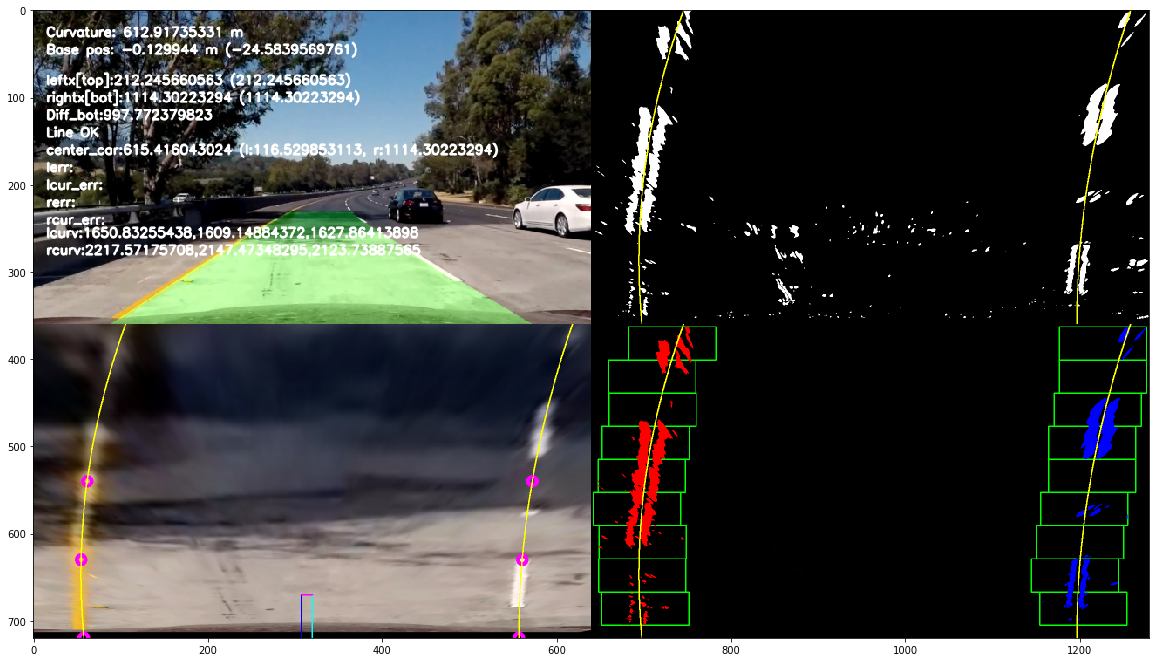

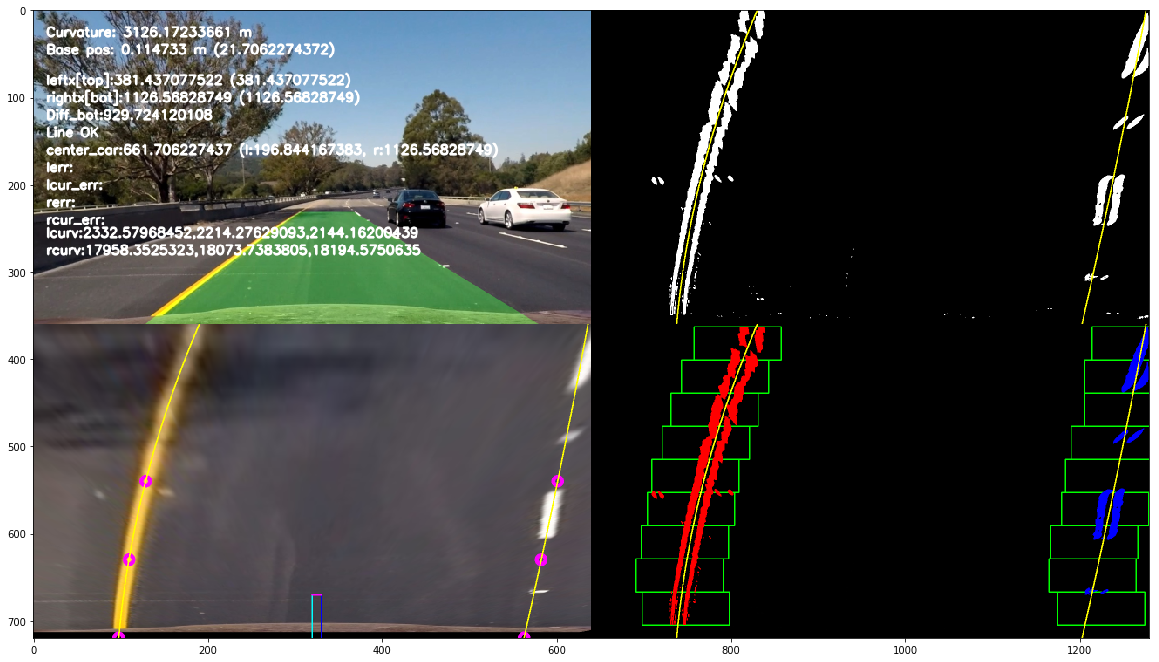

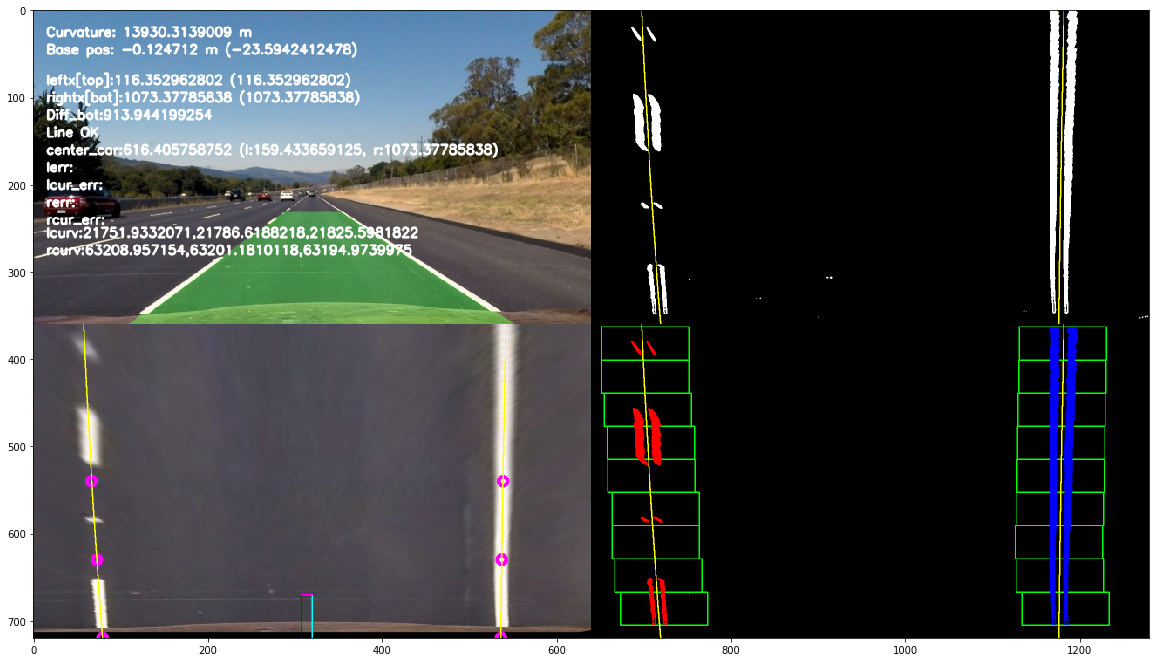

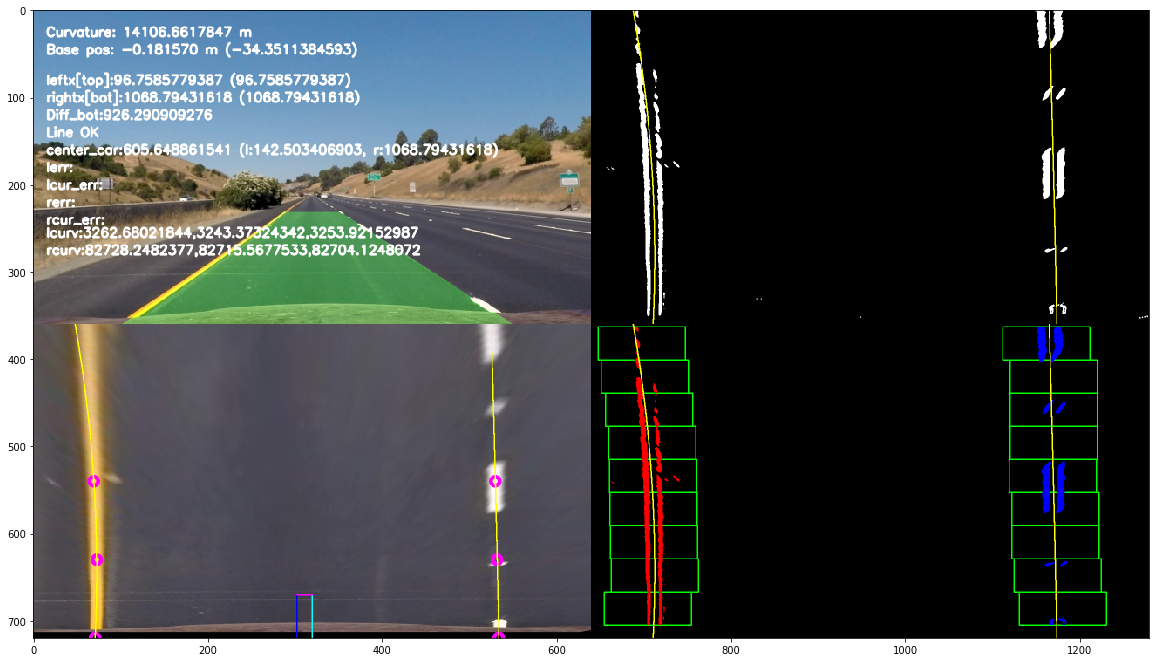

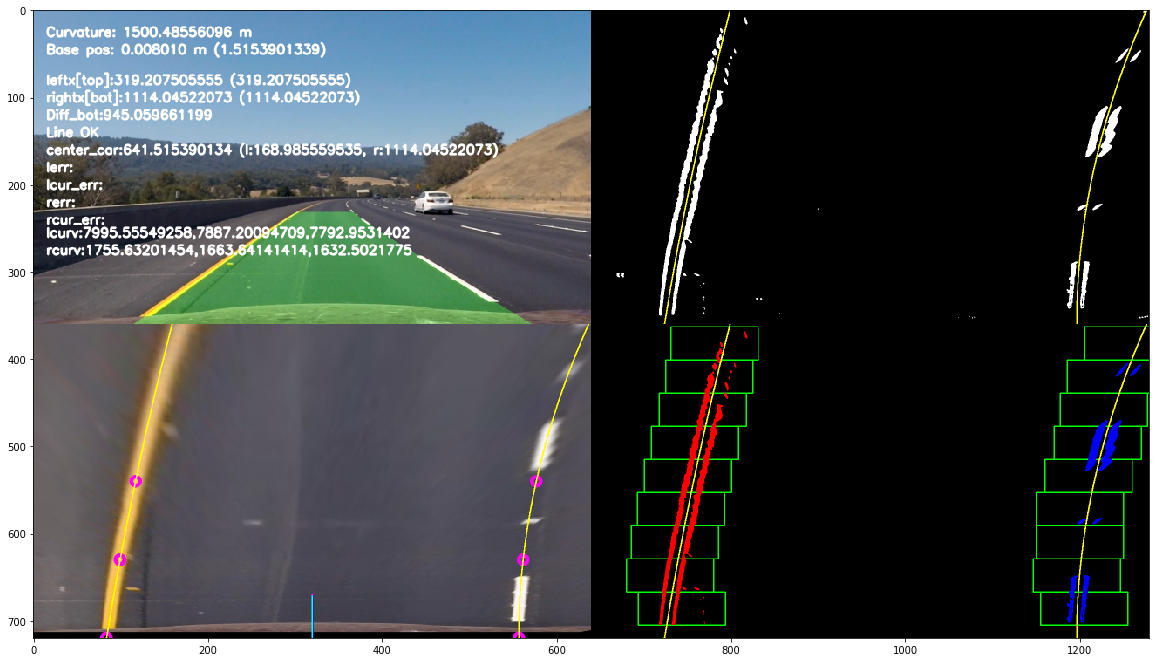

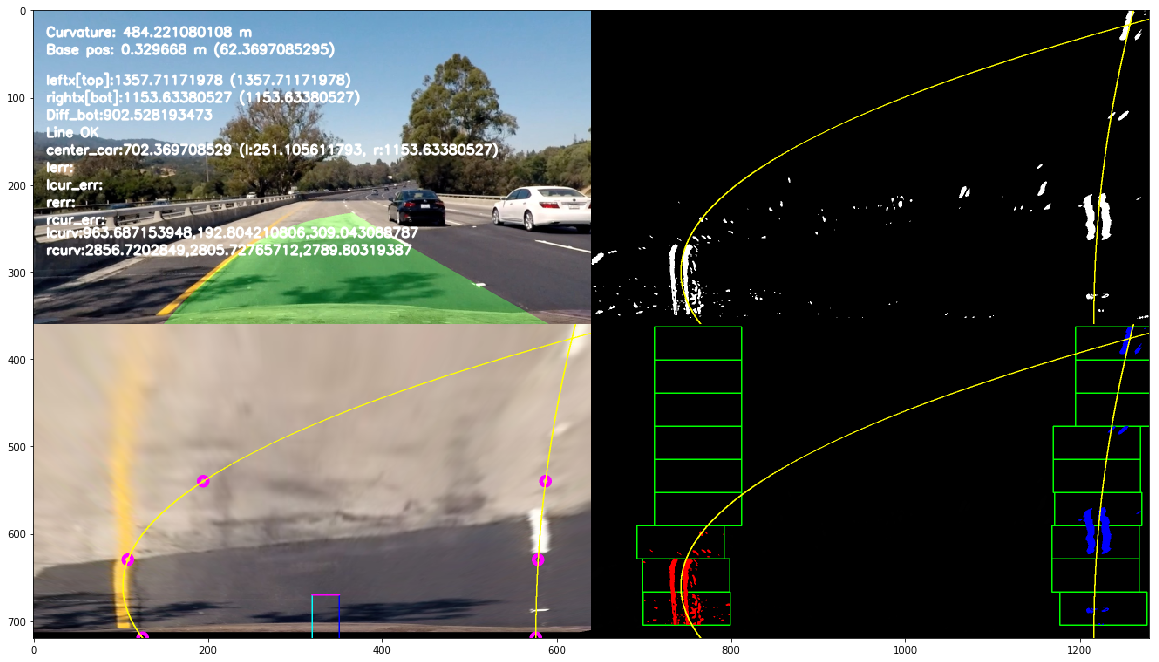

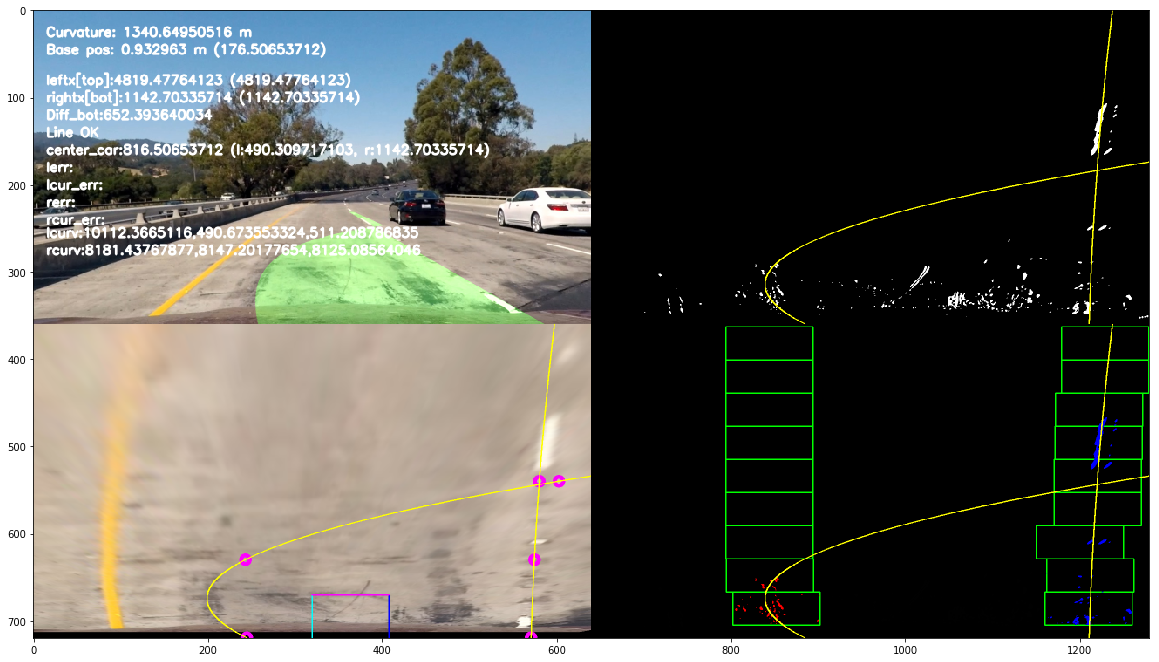

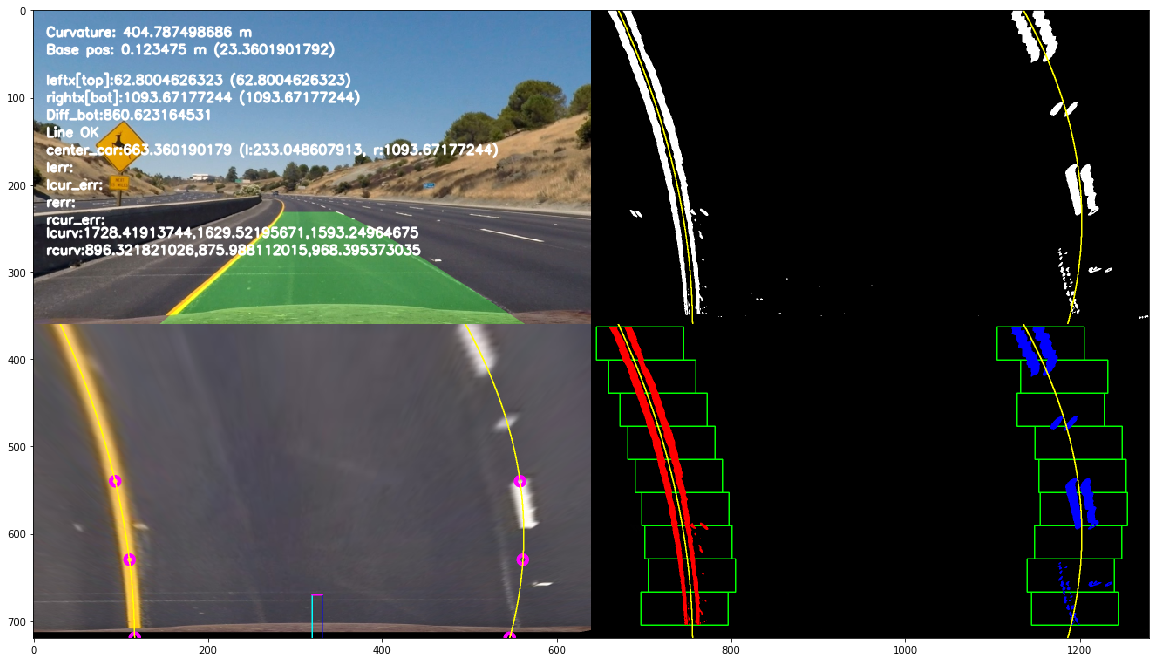

In [24]:
images = glob.glob(test_images + '/*')
for image in images:
    print("Image: ", image)
    left_line = Line()
    right_line = Line()
    plt.rcParams["figure.figsize"]=20,20
    image_bgr = cv2.imread(image)
    result = create_green_path(image_bgr, left_line, right_line, True, True)
    #if not run_long_processes: break
 
    #plt.imshow(result)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position<A name = 'PipelineOnVideo'>


In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [26]:
from datetime import datetime
video_path = 'challenge_video.mp4'
video_path_out = 'out_challenge_video.mp4'
left_line = Line(1)
right_line = Line(1)
print("Started")
def call_create_green_path(image):
    modified_image = create_green_path(image, left_line, right_line, False, False)
    return modified_image


#clip2 = VideoFileClip(video_path).subclip(0, 2)
clip2 = VideoFileClip(video_path)
clip = clip2.fl_image(call_create_green_path)
%time clip.write_videofile(video_path_out, audio=False)

Started
Left lane
Right lane
OK Left lane 
OK Right lane 
[MoviePy] >>>> Building video out_challenge_video.mp4
[MoviePy] Writing video out_challenge_video.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


  0%|          | 2/485 [00:00<01:34,  5.09it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 
Left lane
Right lane
OK Left lane 
OK Right lane 


  1%|          | 4/485 [00:00<01:29,  5.36it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 
Left lane

  1%|          | 6/485 [00:01<01:28,  5.40it/s]


Right lane
OK Left lane 
OK Right lane 
Left lane
Right lane
OK Left lane 
OK Right lane 


  1%|▏         | 7/485 [00:01<01:28,  5.41it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


  2%|▏         | 8/485 [00:01<01:31,  5.22it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 
Left lane
Right lane
ERROR: Size between lanes not correct: 887 Ranges are (695, 870)
Error diff_bot: ERROR: 887 Ranges are (695, 870)
Error failing: ERROR: 887 Ranges are (695, 870) Left line not detected Right line not detected


  2%|▏         | 10/485 [00:01<01:27,  5.41it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


  2%|▏         | 11/485 [00:02<01:31,  5.18it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 871 Ranges are (695, 870)
Error diff_bot: ERROR: 871 Ranges are (695, 870)
Error failing: ERROR: 871 Ranges are (695, 870) Left line not detected Right line not detected
Left lane
Right lane
ERROR: Size between lanes not correct: 875 Ranges are (695, 870)
Error diff_bot: ERROR: 875 Ranges are (695, 870)
Error failing: ERROR: 875 Ranges are (695, 870) Left line not detected Right line not detected


  3%|▎         | 13/485 [00:02<01:28,  5.36it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 874 Ranges are (695, 870)
Error diff_bot: ERROR: 874 Ranges are (695, 870)
Error failing: ERROR: 874 Ranges are (695, 870) Left line not detected Right line not detected


  3%|▎         | 14/485 [00:02<01:31,  5.15it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 905 Ranges are (695, 870)
Error diff_bot: ERROR: 905 Ranges are (695, 870)
Error failing: ERROR: 905 Ranges are (695, 870) Left line not detected Right line not detected
Left lane
Right lane
OK Left lane 
OK Right lane 


  3%|▎         | 16/485 [00:03<01:28,  5.30it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


  4%|▎         | 17/485 [00:03<01:31,  5.10it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 
Left lane
Right lane
ERROR: Size between lanes not correct: 878 Ranges are (695, 870)
Error diff_bot: ERROR: 878 Ranges are (695, 870)
Error failing: ERROR: 878 Ranges are (695, 870) Left line not detected Right line not detected


  4%|▍         | 19/485 [00:03<01:26,  5.39it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


  4%|▍         | 20/485 [00:03<01:28,  5.24it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 
Left lane
Right lane
ERROR: Size between lanes not correct: 873 Ranges are (695, 870)
Error diff_bot: ERROR: 873 Ranges are (695, 870)
Error failing: ERROR: 873 Ranges are (695, 870) Left line not detected Right line not detected


  5%|▍         | 22/485 [00:04<01:26,  5.37it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 877 Ranges are (695, 870)
Error diff_bot: ERROR: 877 Ranges are (695, 870)
Error failing: ERROR: 877 Ranges are (695, 870) Left line not detected Right line not detected


  5%|▍         | 23/485 [00:04<01:29,  5.16it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 879 Ranges are (695, 870)
Error diff_bot: ERROR: 879 Ranges are (695, 870)
Error failing: ERROR: 879 Ranges are (695, 870) Left line not detected Right line not detected
Left lane
Right lane
ERROR: Size between lanes not correct: 870 Ranges are (695, 870)
Error diff_bot: ERROR: 870 Ranges are (695, 870)
Error failing: ERROR: 870 Ranges are (695, 870) Left line not detected Right line not detected


  5%|▌         | 25/485 [00:04<01:25,  5.39it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


  5%|▌         | 26/485 [00:04<01:32,  4.98it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 879 Ranges are (695, 870)
Error diff_bot: ERROR: 879 Ranges are (695, 870)
Error failing: ERROR: 879 Ranges are (695, 870) Left line not detected Right line not detected
Left lane
Right lane
ERROR: Size between lanes not correct: 888 Ranges are (695, 870)
Error diff_bot: ERROR: 888 Ranges are (695, 870)
Error failing: ERROR: 888 Ranges are (695, 870) Left line not detected Right line not detected


  6%|▌         | 28/485 [00:05<01:26,  5.27it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 889 Ranges are (695, 870)
Error diff_bot: ERROR: 889 Ranges are (695, 870)
Error failing: ERROR: 889 Ranges are (695, 870) Left line not detected Right line not detected


  6%|▌         | 29/485 [00:05<01:29,  5.12it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 884 Ranges are (695, 870)
Error diff_bot: ERROR: 884 Ranges are (695, 870)
Error failing: ERROR: 884 Ranges are (695, 870) Left line not detected Right line not detected
Left lane
Right lane
OK Left lane 
OK Right lane 


  6%|▋         | 31/485 [00:05<01:23,  5.41it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 
Left lane
Right lane
OK Left lane 

  7%|▋         | 33/485 [00:06<01:23,  5.41it/s]


OK Right lane 
Left lane
Right lane
Error failing:  Left line not detected Right line not detected


  7%|▋         | 34/485 [00:06<01:22,  5.49it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 900 Ranges are (695, 870)
Error diff_bot: ERROR: 900 Ranges are (695, 870)
Error failing: ERROR: 900 Ranges are (695, 870) Left line not detected Right line not detected
Left lane
Right lane

  7%|▋         | 35/485 [00:06<01:24,  5.33it/s]


Error failing:  Left line not detected Right line not detected
Left lane
Right lane
Error failing:  Left line not detected Right line not detected


  8%|▊         | 37/485 [00:07<01:22,  5.45it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected
Left lane

  8%|▊         | 39/485 [00:07<01:22,  5.42it/s]


Right lane
Error failing:  Left line not detected Right line not detected
Left lane
Right lane
Error failing:  Left line not detected Right line not detected


  8%|▊         | 40/485 [00:07<01:21,  5.49it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


  8%|▊         | 41/485 [00:07<01:24,  5.27it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected
Left lane
Right lane
Error failing:  Left line not detected Right line not detected


  9%|▉         | 43/485 [00:08<02:01,  3.63it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 909 Ranges are (695, 870)
Error diff_bot: ERROR: 909 Ranges are (695, 870)
Error failing: ERROR: 909 Ranges are (695, 870) Left line not detected Right line not detected


  9%|▉         | 44/485 [00:08<02:01,  3.62it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 920 Ranges are (695, 870)
Error diff_bot: ERROR: 920 Ranges are (695, 870)
Error failing: ERROR: 920 Ranges are (695, 870) Left line not detected Right line not detected


  9%|▉         | 45/485 [00:08<01:54,  3.85it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 958 Ranges are (695, 870)
Error diff_bot: ERROR: 958 Ranges are (695, 870)
Error failing: ERROR: 958 Ranges are (695, 870) Left line not detected Right line not detected


  9%|▉         | 46/485 [00:09<01:49,  4.02it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 948 Ranges are (695, 870)
Error diff_bot: ERROR: 948 Ranges are (695, 870)
Error failing: ERROR: 948 Ranges are (695, 870) Left line not detected Right line not detected


 10%|▉         | 47/485 [00:09<01:57,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 10%|▉         | 48/485 [00:09<01:52,  3.87it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 897 Ranges are (695, 870)
Error diff_bot: ERROR: 897 Ranges are (695, 870)
Error failing: ERROR: 897 Ranges are (695, 870) Left line not detected Right line not detected


 10%|█         | 49/485 [00:09<01:49,  3.99it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 898 Ranges are (695, 870)
Error diff_bot: ERROR: 898 Ranges are (695, 870)
Error failing: ERROR: 898 Ranges are (695, 870) Left line not detected Right line not detected


 10%|█         | 50/485 [00:10<01:58,  3.69it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 905 Ranges are (695, 870)
Error diff_bot: ERROR: 905 Ranges are (695, 870)
Error failing: ERROR: 905 Ranges are (695, 870) Left line not detected Right line not detected


 11%|█         | 51/485 [00:10<01:52,  3.85it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 912 Ranges are (695, 870)
Error diff_bot: ERROR: 912 Ranges are (695, 870)
Error failing: ERROR: 912 Ranges are (695, 870) Left line not detected Right line not detected


 11%|█         | 52/485 [00:10<01:48,  3.98it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 913 Ranges are (695, 870)
Error diff_bot: ERROR: 913 Ranges are (695, 870)
Error failing: ERROR: 913 Ranges are (695, 870) Left line not detected Right line not detected


 11%|█         | 53/485 [00:11<01:56,  3.71it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 919 Ranges are (695, 870)
Error diff_bot: ERROR: 919 Ranges are (695, 870)
Error failing: ERROR: 919 Ranges are (695, 870) Left line not detected Right line not detected


 11%|█         | 54/485 [00:11<01:52,  3.82it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 907 Ranges are (695, 870)
Error diff_bot: ERROR: 907 Ranges are (695, 870)
Error failing: ERROR: 907 Ranges are (695, 870) Left line not detected Right line not detected


 11%|█▏        | 55/485 [00:11<01:49,  3.94it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 915 Ranges are (695, 870)
Error diff_bot: ERROR: 915 Ranges are (695, 870)
Error failing: ERROR: 915 Ranges are (695, 870) Left line not detected Right line not detected


 12%|█▏        | 56/485 [00:11<01:57,  3.64it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 918 Ranges are (695, 870)
Error diff_bot: ERROR: 918 Ranges are (695, 870)
Error failing: ERROR: 918 Ranges are (695, 870) Left line not detected Right line not detected


 12%|█▏        | 57/485 [00:12<01:53,  3.78it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 920 Ranges are (695, 870)
Error diff_bot: ERROR: 920 Ranges are (695, 870)
Error failing: ERROR: 920 Ranges are (695, 870) Left line not detected Right line not detected


 12%|█▏        | 58/485 [00:12<01:48,  3.93it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 920 Ranges are (695, 870)
Error diff_bot: ERROR: 920 Ranges are (695, 870)
Error failing: ERROR: 920 Ranges are (695, 870) Left line not detected Right line not detected


 12%|█▏        | 59/485 [00:12<01:55,  3.68it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 926 Ranges are (695, 870)
Error diff_bot: ERROR: 926 Ranges are (695, 870)
Error failing: ERROR: 926 Ranges are (695, 870) Left line not detected Right line not detected


 12%|█▏        | 60/485 [00:12<01:52,  3.79it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 938 Ranges are (695, 870)
Error diff_bot: ERROR: 938 Ranges are (695, 870)
Error failing: ERROR: 938 Ranges are (695, 870) Left line not detected Right line not detected


 13%|█▎        | 61/485 [00:13<01:47,  3.94it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 13%|█▎        | 62/485 [00:13<01:53,  3.72it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 13%|█▎        | 63/485 [00:13<01:48,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 13%|█▎        | 64/485 [00:13<01:45,  3.98it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 13%|█▎        | 65/485 [00:14<01:54,  3.66it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 14%|█▎        | 66/485 [00:14<01:49,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 14%|█▍        | 67/485 [00:14<01:45,  3.95it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 14%|█▍        | 68/485 [00:14<01:52,  3.69it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 684 Ranges are (695, 870)
Error diff_bot: ERROR: 684 Ranges are (695, 870)
Error failing: ERROR: 684 Ranges are (695, 870) Left line not detected Right line not detected


 14%|█▍        | 69/485 [00:15<01:48,  3.82it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 14%|█▍        | 70/485 [00:15<01:45,  3.94it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 15%|█▍        | 71/485 [00:15<01:50,  3.75it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 693 Ranges are (695, 870)
Error diff_bot: ERROR: 693 Ranges are (695, 870)
Error failing: ERROR: 693 Ranges are (695, 870) Left line not detected Right line not detected


 15%|█▍        | 72/485 [00:15<01:44,  3.94it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 690 Ranges are (695, 870)
Error diff_bot: ERROR: 690 Ranges are (695, 870)
Error failing: ERROR: 690 Ranges are (695, 870) Left line not detected Right line not detected


 15%|█▌        | 73/485 [00:16<01:49,  3.77it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 689 Ranges are (695, 870)
Error diff_bot: ERROR: 689 Ranges are (695, 870)
Error failing: ERROR: 689 Ranges are (695, 870) Left line not detected Right line not detected


 15%|█▌        | 74/485 [00:16<01:47,  3.83it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 688 Ranges are (695, 870)
Error diff_bot: ERROR: 688 Ranges are (695, 870)
Error failing: ERROR: 688 Ranges are (695, 870) Left line not detected Right line not detected


 15%|█▌        | 75/485 [00:16<01:48,  3.78it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 16%|█▌        | 76/485 [00:17<01:44,  3.93it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 690 Ranges are (695, 870)
Error diff_bot: ERROR: 690 Ranges are (695, 870)
Error failing: ERROR: 690 Ranges are (695, 870) Left line not detected Right line not detected


 16%|█▌        | 77/485 [00:17<01:43,  3.94it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 16%|█▌        | 78/485 [00:17<01:47,  3.79it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 16%|█▋        | 79/485 [00:17<01:43,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 16%|█▋        | 80/485 [00:18<01:44,  3.89it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 671 Ranges are (695, 870)
Error diff_bot: ERROR: 671 Ranges are (695, 870)
Error failing: ERROR: 671 Ranges are (695, 870) Left line not detected Right line not detected


 17%|█▋        | 81/485 [00:18<01:48,  3.74it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 674 Ranges are (695, 870)
Error diff_bot: ERROR: 674 Ranges are (695, 870)
Error failing: ERROR: 674 Ranges are (695, 870) Left line not detected Right line not detected


 17%|█▋        | 82/485 [00:18<01:43,  3.88it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 684 Ranges are (695, 870)
Error diff_bot: ERROR: 684 Ranges are (695, 870)
Error failing: ERROR: 684 Ranges are (695, 870) Left line not detected Right line not detected


 17%|█▋        | 83/485 [00:18<01:43,  3.88it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 685 Ranges are (695, 870)
Error diff_bot: ERROR: 685 Ranges are (695, 870)
Error failing: ERROR: 685 Ranges are (695, 870) Left line not detected Right line not detected


 17%|█▋        | 84/485 [00:19<01:46,  3.75it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 18%|█▊        | 85/485 [00:19<01:43,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 18%|█▊        | 86/485 [00:19<01:43,  3.84it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 18%|█▊        | 87/485 [00:19<01:46,  3.72it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 18%|█▊        | 88/485 [00:20<01:42,  3.86it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 693 Ranges are (695, 870)
Error diff_bot: ERROR: 693 Ranges are (695, 870)
Error failing: ERROR: 693 Ranges are (695, 870) Left line not detected Right line not detected


 18%|█▊        | 89/485 [00:20<01:42,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 19%|█▊        | 90/485 [00:20<01:45,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 19%|█▉        | 91/485 [00:20<01:41,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 19%|█▉        | 92/485 [00:21<01:43,  3.79it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 901 Ranges are (695, 870)
Error diff_bot: ERROR: 901 Ranges are (695, 870)
Error failing: ERROR: 901 Ranges are (695, 870) Left line not detected Right line not detected


 19%|█▉        | 93/485 [00:21<01:47,  3.66it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 19%|█▉        | 94/485 [00:21<01:42,  3.81it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 20%|█▉        | 95/485 [00:22<01:42,  3.81it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 20%|█▉        | 96/485 [00:22<01:45,  3.70it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 20%|██        | 97/485 [00:22<01:41,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 20%|██        | 98/485 [00:22<01:41,  3.82it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 20%|██        | 99/485 [00:23<01:44,  3.69it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 21%|██        | 100/485 [00:23<01:40,  3.82it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 21%|██        | 101/485 [00:23<01:40,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 21%|██        | 102/485 [00:23<01:43,  3.70it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 21%|██        | 103/485 [00:24<01:39,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 21%|██▏       | 104/485 [00:24<01:43,  3.66it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 22%|██▏       | 105/485 [00:24<01:38,  3.85it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 22%|██▏       | 106/485 [00:24<01:41,  3.75it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 22%|██▏       | 107/485 [00:25<01:40,  3.78it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 22%|██▏       | 108/485 [00:25<01:41,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 22%|██▏       | 109/485 [00:25<01:36,  3.90it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 23%|██▎       | 110/485 [00:25<01:41,  3.70it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 23%|██▎       | 111/485 [00:26<01:36,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 23%|██▎       | 112/485 [00:26<01:37,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 23%|██▎       | 113/485 [00:26<01:36,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 24%|██▎       | 114/485 [00:27<01:36,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 24%|██▎       | 115/485 [00:27<01:32,  4.00it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 24%|██▍       | 116/485 [00:27<01:37,  3.79it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 24%|██▍       | 117/485 [00:27<01:32,  3.99it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 24%|██▍       | 118/485 [00:28<01:34,  3.89it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 873 Ranges are (695, 870)
Error diff_bot: ERROR: 873 Ranges are (695, 870)
Error failing: ERROR: 873 Ranges are (695, 870) Left line not detected Right line not detected


 25%|██▍       | 119/485 [00:28<01:33,  3.93it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 25%|██▍       | 120/485 [00:28<01:35,  3.83it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 873 Ranges are (695, 870)
Error diff_bot: ERROR: 873 Ranges are (695, 870)
Error failing: ERROR: 873 Ranges are (695, 870) Left line not detected Right line not detected


 25%|██▍       | 121/485 [00:28<01:31,  3.98it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 25%|██▌       | 122/485 [00:29<01:35,  3.80it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 25%|██▌       | 123/485 [00:29<01:31,  3.98it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 26%|██▌       | 124/485 [00:29<01:32,  3.90it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 26%|██▌       | 125/485 [00:29<01:31,  3.94it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 26%|██▌       | 126/485 [00:30<01:32,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 26%|██▌       | 127/485 [00:30<01:29,  4.01it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 26%|██▋       | 128/485 [00:30<01:33,  3.82it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 27%|██▋       | 129/485 [00:30<01:29,  3.97it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 27%|██▋       | 130/485 [00:31<01:31,  3.90it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 27%|██▋       | 131/485 [00:31<01:29,  3.94it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 27%|██▋       | 132/485 [00:31<01:32,  3.82it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 27%|██▋       | 133/485 [00:31<01:28,  3.97it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 28%|██▊       | 134/485 [00:32<01:33,  3.74it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 28%|██▊       | 135/485 [00:32<01:30,  3.86it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 28%|██▊       | 136/485 [00:32<01:32,  3.78it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 28%|██▊       | 137/485 [00:32<01:32,  3.77it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 28%|██▊       | 138/485 [00:33<01:34,  3.67it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 29%|██▊       | 139/485 [00:33<01:31,  3.79it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 29%|██▉       | 140/485 [00:33<01:35,  3.59it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 29%|██▉       | 141/485 [00:34<01:32,  3.73it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 29%|██▉       | 142/485 [00:34<01:33,  3.65it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 29%|██▉       | 143/485 [00:34<01:33,  3.67it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 30%|██▉       | 144/485 [00:34<01:34,  3.60it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 30%|██▉       | 145/485 [00:35<01:31,  3.70it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 30%|███       | 146/485 [00:35<01:36,  3.51it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 30%|███       | 147/485 [00:35<01:33,  3.62it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 31%|███       | 148/485 [00:35<01:34,  3.56it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 693 Ranges are (695, 870)
Error diff_bot: ERROR: 693 Ranges are (695, 870)
Error failing: ERROR: 693 Ranges are (695, 870) Left line not detected Right line not detected


 31%|███       | 149/485 [00:36<01:33,  3.60it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 31%|███       | 150/485 [00:36<01:33,  3.57it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 31%|███       | 151/485 [00:36<01:39,  3.35it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 31%|███▏      | 152/485 [00:37<01:37,  3.43it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 32%|███▏      | 153/485 [00:37<01:34,  3.50it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 32%|███▏      | 154/485 [00:37<01:32,  3.57it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 32%|███▏      | 155/485 [00:38<01:35,  3.46it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 32%|███▏      | 156/485 [00:38<01:30,  3.63it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 32%|███▏      | 157/485 [00:38<01:30,  3.63it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 33%|███▎      | 158/485 [00:38<01:31,  3.58it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 33%|███▎      | 159/485 [00:39<01:29,  3.62it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 33%|███▎      | 160/485 [00:39<01:28,  3.66it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 33%|███▎      | 161/485 [00:39<01:30,  3.58it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 33%|███▎      | 162/485 [00:40<01:44,  3.08it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 34%|███▎      | 163/485 [00:40<01:56,  2.76it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 34%|███▍      | 164/485 [00:40<02:00,  2.66it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 34%|███▍      | 165/485 [00:41<02:03,  2.59it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 34%|███▍      | 166/485 [00:41<02:01,  2.62it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 34%|███▍      | 167/485 [00:42<01:52,  2.82it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 35%|███▍      | 168/485 [00:42<01:46,  2.97it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 35%|███▍      | 169/485 [00:42<01:40,  3.13it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 35%|███▌      | 170/485 [00:42<01:38,  3.20it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 35%|███▌      | 171/485 [00:43<01:33,  3.36it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 35%|███▌      | 172/485 [00:43<01:30,  3.47it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 36%|███▌      | 173/485 [00:43<01:30,  3.45it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 36%|███▌      | 174/485 [00:43<01:28,  3.53it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 36%|███▌      | 175/485 [00:44<01:26,  3.57it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 36%|███▋      | 176/485 [00:44<01:27,  3.54it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 36%|███▋      | 177/485 [00:44<01:25,  3.60it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 37%|███▋      | 178/485 [00:45<01:24,  3.64it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 37%|███▋      | 179/485 [00:45<01:25,  3.57it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 37%|███▋      | 180/485 [00:45<01:24,  3.62it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 37%|███▋      | 181/485 [00:45<01:22,  3.67it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 38%|███▊      | 182/485 [00:46<01:24,  3.57it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 38%|███▊      | 183/485 [00:46<01:23,  3.62it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 38%|███▊      | 184/485 [00:46<01:23,  3.62it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 38%|███▊      | 185/485 [00:47<01:23,  3.58it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 38%|███▊      | 186/485 [00:47<01:21,  3.65it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 39%|███▊      | 187/485 [00:47<01:20,  3.72it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 39%|███▉      | 188/485 [00:47<01:21,  3.63it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 39%|███▉      | 189/485 [00:48<01:20,  3.68it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 39%|███▉      | 190/485 [00:48<01:20,  3.66it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 39%|███▉      | 191/485 [00:48<01:19,  3.70it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 40%|███▉      | 192/485 [00:48<01:19,  3.69it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 40%|███▉      | 193/485 [00:49<01:22,  3.53it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 40%|████      | 194/485 [00:49<01:20,  3.64it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 40%|████      | 195/485 [00:49<01:19,  3.63it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 40%|████      | 196/485 [00:49<01:15,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 41%|████      | 197/485 [00:50<01:18,  3.65it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 41%|████      | 198/485 [00:50<01:14,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 41%|████      | 199/485 [00:50<01:15,  3.80it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 41%|████      | 200/485 [00:51<01:16,  3.71it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 41%|████▏     | 201/485 [00:51<01:16,  3.74it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 42%|████▏     | 202/485 [00:51<01:16,  3.70it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 42%|████▏     | 203/485 [00:51<01:18,  3.58it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 42%|████▏     | 204/485 [00:52<01:14,  3.77it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 42%|████▏     | 205/485 [00:52<01:17,  3.61it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 42%|████▏     | 206/485 [00:52<01:15,  3.68it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 43%|████▎     | 207/485 [00:52<01:16,  3.63it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 43%|████▎     | 208/485 [00:53<01:12,  3.81it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 43%|████▎     | 209/485 [00:53<01:18,  3.53it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 43%|████▎     | 210/485 [00:53<01:13,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 44%|████▎     | 211/485 [00:54<01:14,  3.68it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 44%|████▎     | 212/485 [00:54<01:12,  3.78it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 44%|████▍     | 213/485 [00:54<01:12,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 44%|████▍     | 214/485 [00:54<01:09,  3.93it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 44%|████▍     | 215/485 [00:55<01:14,  3.63it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 45%|████▍     | 216/485 [00:55<01:10,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 45%|████▍     | 217/485 [00:55<01:11,  3.76it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 45%|████▍     | 218/485 [00:55<01:10,  3.81it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 45%|████▌     | 219/485 [00:56<01:12,  3.65it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 45%|████▌     | 220/485 [00:56<01:08,  3.84it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 46%|████▌     | 221/485 [00:56<01:11,  3.67it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 46%|████▌     | 222/485 [00:56<01:08,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 46%|████▌     | 223/485 [00:57<01:12,  3.59it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 46%|████▌     | 224/485 [00:57<01:10,  3.68it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 46%|████▋     | 225/485 [00:57<01:10,  3.66it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 47%|████▋     | 226/485 [00:58<01:06,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 47%|████▋     | 227/485 [00:58<01:10,  3.68it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 47%|████▋     | 228/485 [00:58<01:06,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 47%|████▋     | 229/485 [00:58<01:10,  3.66it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 47%|████▋     | 230/485 [00:59<01:08,  3.74it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 48%|████▊     | 231/485 [00:59<01:09,  3.67it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 48%|████▊     | 232/485 [00:59<01:05,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 48%|████▊     | 233/485 [00:59<01:09,  3.60it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 48%|████▊     | 234/485 [01:00<01:05,  3.82it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 48%|████▊     | 235/485 [01:00<01:07,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 49%|████▊     | 236/485 [01:00<01:06,  3.76it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 49%|████▉     | 237/485 [01:00<01:06,  3.70it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 49%|████▉     | 238/485 [01:01<01:03,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 49%|████▉     | 239/485 [01:01<01:08,  3.58it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 49%|████▉     | 240/485 [01:01<01:04,  3.77it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 50%|████▉     | 241/485 [01:02<01:05,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 50%|████▉     | 242/485 [01:02<01:03,  3.81it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 50%|█████     | 243/485 [01:02<01:05,  3.67it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 50%|█████     | 244/485 [01:02<01:02,  3.84it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 51%|█████     | 245/485 [01:03<01:07,  3.58it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 51%|█████     | 246/485 [01:03<01:03,  3.77it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 51%|█████     | 247/485 [01:03<01:04,  3.71it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 51%|█████     | 248/485 [01:03<01:03,  3.75it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 51%|█████▏    | 249/485 [01:04<01:01,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 52%|█████▏    | 250/485 [01:04<01:03,  3.72it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 52%|█████▏    | 251/485 [01:04<01:02,  3.72it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 52%|█████▏    | 252/485 [01:04<01:00,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 52%|█████▏    | 253/485 [01:05<01:02,  3.69it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 52%|█████▏    | 254/485 [01:05<01:01,  3.75it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 53%|█████▎    | 255/485 [01:05<01:02,  3.68it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 53%|█████▎    | 256/485 [01:06<00:59,  3.85it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 53%|█████▎    | 257/485 [01:06<00:59,  3.85it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 53%|█████▎    | 258/485 [01:06<01:00,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 53%|█████▎    | 259/485 [01:06<00:58,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 54%|█████▎    | 260/485 [01:07<00:58,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 54%|█████▍    | 261/485 [01:07<01:00,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 54%|█████▍    | 262/485 [01:07<00:57,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 54%|█████▍    | 263/485 [01:07<00:57,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 54%|█████▍    | 264/485 [01:08<00:59,  3.72it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 55%|█████▍    | 265/485 [01:08<00:56,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 55%|█████▍    | 266/485 [01:08<00:56,  3.85it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 55%|█████▌    | 267/485 [01:08<00:58,  3.70it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 55%|█████▌    | 268/485 [01:09<00:56,  3.81it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 55%|█████▌    | 269/485 [01:09<00:56,  3.84it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 56%|█████▌    | 270/485 [01:09<00:58,  3.70it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 56%|█████▌    | 271/485 [01:09<00:55,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 56%|█████▌    | 272/485 [01:10<00:57,  3.72it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 56%|█████▋    | 273/485 [01:10<00:54,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 56%|█████▋    | 274/485 [01:10<00:55,  3.80it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 57%|█████▋    | 275/485 [01:11<00:54,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 57%|█████▋    | 276/485 [01:11<00:56,  3.69it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 57%|█████▋    | 277/485 [01:11<00:53,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 57%|█████▋    | 278/485 [01:11<00:53,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 58%|█████▊    | 279/485 [01:12<00:55,  3.71it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 58%|█████▊    | 280/485 [01:12<00:53,  3.85it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 58%|█████▊    | 281/485 [01:12<00:52,  3.85it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 58%|█████▊    | 282/485 [01:12<00:54,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 58%|█████▊    | 283/485 [01:13<00:51,  3.92it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 59%|█████▊    | 284/485 [01:13<00:53,  3.74it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 59%|█████▉    | 285/485 [01:13<00:51,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 59%|█████▉    | 286/485 [01:13<00:49,  4.00it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 59%|█████▉    | 287/485 [01:14<00:53,  3.67it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 59%|█████▉    | 288/485 [01:14<00:51,  3.81it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 60%|█████▉    | 289/485 [01:14<00:49,  3.93it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 60%|█████▉    | 290/485 [01:14<00:53,  3.66it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 60%|██████    | 291/485 [01:15<00:51,  3.78it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 60%|██████    | 292/485 [01:15<00:49,  3.93it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 60%|██████    | 293/485 [01:15<00:54,  3.51it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 61%|██████    | 294/485 [01:16<00:51,  3.68it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 61%|██████    | 295/485 [01:16<00:48,  3.89it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 61%|██████    | 296/485 [01:16<00:48,  3.93it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 61%|██████    | 297/485 [01:16<00:49,  3.78it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 61%|██████▏   | 298/485 [01:17<00:48,  3.89it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 62%|██████▏   | 299/485 [01:17<00:47,  3.89it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 62%|██████▏   | 300/485 [01:17<00:49,  3.76it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 62%|██████▏   | 301/485 [01:17<00:46,  3.93it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 62%|██████▏   | 302/485 [01:18<00:46,  3.92it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 62%|██████▏   | 303/485 [01:18<00:48,  3.77it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 63%|██████▎   | 304/485 [01:18<00:46,  3.90it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 63%|██████▎   | 305/485 [01:18<00:46,  3.89it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 63%|██████▎   | 306/485 [01:19<00:47,  3.75it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 63%|██████▎   | 307/485 [01:19<00:46,  3.83it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 64%|██████▎   | 308/485 [01:19<00:46,  3.82it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 64%|██████▎   | 309/485 [01:19<00:47,  3.71it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 64%|██████▍   | 310/485 [01:20<00:45,  3.87it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 64%|██████▍   | 311/485 [01:20<00:46,  3.72it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 64%|██████▍   | 312/485 [01:20<00:44,  3.88it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 65%|██████▍   | 313/485 [01:21<00:45,  3.75it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 65%|██████▍   | 314/485 [01:21<00:45,  3.78it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 65%|██████▍   | 315/485 [01:21<00:45,  3.71it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 65%|██████▌   | 316/485 [01:21<00:43,  3.86it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 65%|██████▌   | 317/485 [01:22<00:43,  3.82it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 66%|██████▌   | 318/485 [01:22<00:44,  3.72it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 66%|██████▌   | 319/485 [01:22<00:42,  3.88it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 66%|██████▌   | 320/485 [01:22<00:44,  3.70it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 66%|██████▌   | 321/485 [01:23<00:43,  3.81it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 66%|██████▋   | 322/485 [01:23<00:43,  3.75it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 67%|██████▋   | 323/485 [01:23<00:42,  3.80it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 67%|██████▋   | 324/485 [01:23<00:43,  3.74it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 67%|██████▋   | 325/485 [01:24<00:40,  3.92it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 67%|██████▋   | 326/485 [01:24<00:42,  3.70it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 67%|██████▋   | 327/485 [01:24<00:40,  3.87it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 68%|██████▊   | 328/485 [01:24<00:41,  3.81it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 68%|██████▊   | 329/485 [01:25<00:40,  3.86it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 68%|██████▊   | 330/485 [01:25<00:41,  3.78it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 68%|██████▊   | 331/485 [01:25<00:39,  3.95it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 68%|██████▊   | 332/485 [01:26<00:41,  3.69it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 69%|██████▊   | 333/485 [01:26<00:39,  3.86it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 69%|██████▉   | 334/485 [01:26<00:39,  3.80it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 69%|██████▉   | 335/485 [01:26<00:39,  3.83it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 69%|██████▉   | 336/485 [01:27<00:39,  3.75it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 69%|██████▉   | 337/485 [01:27<00:37,  3.92it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 70%|██████▉   | 338/485 [01:27<00:39,  3.76it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 70%|██████▉   | 339/485 [01:27<00:37,  3.93it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 70%|███████   | 340/485 [01:28<00:37,  3.87it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 70%|███████   | 341/485 [01:28<00:36,  3.91it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 71%|███████   | 342/485 [01:28<00:37,  3.79it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 71%|███████   | 343/485 [01:28<00:35,  3.95it/s]

Left lane
Right lane
Error failing:  Right line not detected
OK Left lane 


 71%|███████   | 344/485 [01:29<00:41,  3.42it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 71%|███████   | 345/485 [01:29<00:45,  3.10it/s]

Left lane
Right lane
Error failing:  Right line not detected
OK Left lane 


 71%|███████▏  | 346/485 [01:30<00:49,  2.81it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 72%|███████▏  | 347/485 [01:30<00:52,  2.65it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 72%|███████▏  | 348/485 [01:30<00:52,  2.63it/s]

Left lane
Right lane
Error failing:  Right line not detected
OK Left lane 


 72%|███████▏  | 349/485 [01:31<00:51,  2.62it/s]

Left lane
Right lane
Error failing:  Right line not detected
OK Left lane 


 72%|███████▏  | 350/485 [01:31<00:51,  2.63it/s]

Left lane
Right lane
Error failing:  Right line not detected
OK Left lane 


 72%|███████▏  | 351/485 [01:31<00:44,  3.00it/s]

Left lane
Right lane
Error failing:  Right line not detected
OK Left lane 


 73%|███████▎  | 352/485 [01:32<00:41,  3.18it/s]

Left lane
Right lane
Error failing:  Right line not detected
OK Left lane 


 73%|███████▎  | 353/485 [01:32<00:39,  3.38it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 73%|███████▎  | 354/485 [01:32<00:38,  3.43it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 73%|███████▎  | 355/485 [01:32<00:35,  3.66it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 73%|███████▎  | 356/485 [01:33<00:36,  3.55it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 74%|███████▎  | 357/485 [01:33<00:34,  3.75it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 74%|███████▍  | 358/485 [01:33<00:34,  3.71it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 74%|███████▍  | 359/485 [01:33<00:33,  3.72it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 74%|███████▍  | 360/485 [01:34<00:34,  3.61it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 74%|███████▍  | 361/485 [01:34<00:33,  3.74it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 75%|███████▍  | 362/485 [01:34<00:34,  3.55it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 75%|███████▍  | 363/485 [01:35<00:33,  3.68it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 75%|███████▌  | 364/485 [01:35<00:33,  3.66it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 75%|███████▌  | 365/485 [01:35<00:32,  3.73it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 75%|███████▌  | 366/485 [01:35<00:31,  3.73it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 76%|███████▌  | 367/485 [01:36<00:30,  3.91it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 76%|███████▌  | 368/485 [01:36<00:31,  3.70it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 76%|███████▌  | 369/485 [01:36<00:30,  3.86it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 76%|███████▋  | 370/485 [01:36<00:30,  3.81it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 76%|███████▋  | 371/485 [01:37<00:29,  3.84it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 77%|███████▋  | 372/485 [01:37<00:29,  3.84it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 77%|███████▋  | 373/485 [01:37<00:29,  3.75it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 77%|███████▋  | 374/485 [01:37<00:29,  3.80it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 77%|███████▋  | 375/485 [01:38<00:29,  3.74it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 78%|███████▊  | 376/485 [01:38<00:27,  3.90it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 78%|███████▊  | 377/485 [01:38<00:28,  3.74it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 78%|███████▊  | 378/485 [01:38<00:27,  3.93it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 78%|███████▊  | 379/485 [01:39<00:27,  3.87it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 78%|███████▊  | 380/485 [01:39<00:26,  3.92it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 79%|███████▊  | 381/485 [01:39<00:26,  3.88it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 79%|███████▉  | 382/485 [01:39<00:25,  4.00it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 79%|███████▉  | 383/485 [01:40<00:27,  3.76it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 79%|███████▉  | 384/485 [01:40<00:25,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 79%|███████▉  | 385/485 [01:40<00:26,  3.80it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 80%|███████▉  | 386/485 [01:41<00:25,  3.81it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 80%|███████▉  | 387/485 [01:41<00:25,  3.89it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 80%|████████  | 388/485 [01:41<00:25,  3.79it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 80%|████████  | 389/485 [01:41<00:25,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 80%|████████  | 390/485 [01:42<00:25,  3.76it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 81%|████████  | 391/485 [01:42<00:23,  3.93it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 883 Ranges are (695, 870)
Error diff_bot: ERROR: 883 Ranges are (695, 870)
Error failing: ERROR: 883 Ranges are (695, 870) Left line not detected Right line not detected


 81%|████████  | 392/485 [01:42<00:24,  3.76it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 81%|████████  | 393/485 [01:42<00:23,  3.95it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 878 Ranges are (695, 870)
Error diff_bot: ERROR: 878 Ranges are (695, 870)
Error failing: ERROR: 878 Ranges are (695, 870) Left line not detected Right line not detected


 81%|████████  | 394/485 [01:43<00:23,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 81%|████████▏ | 395/485 [01:43<00:23,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 82%|████████▏ | 396/485 [01:43<00:22,  3.95it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 82%|████████▏ | 397/485 [01:43<00:23,  3.79it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 82%|████████▏ | 398/485 [01:44<00:22,  3.79it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 82%|████████▏ | 399/485 [01:44<00:21,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 82%|████████▏ | 400/485 [01:44<00:22,  3.79it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 83%|████████▎ | 401/485 [01:44<00:21,  3.82it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 83%|████████▎ | 402/485 [01:45<00:20,  3.96it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 83%|████████▎ | 403/485 [01:45<00:21,  3.80it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 83%|████████▎ | 404/485 [01:45<00:20,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 84%|████████▎ | 405/485 [01:46<00:21,  3.81it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 84%|████████▎ | 406/485 [01:46<00:20,  3.94it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 84%|████████▍ | 407/485 [01:46<00:19,  3.93it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 84%|████████▍ | 408/485 [01:46<00:19,  3.85it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 84%|████████▍ | 409/485 [01:46<00:18,  4.02it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 85%|████████▍ | 410/485 [01:47<00:19,  3.82it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 85%|████████▍ | 411/485 [01:47<00:18,  3.99it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 85%|████████▍ | 412/485 [01:47<00:18,  3.89it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 85%|████████▌ | 413/485 [01:48<00:18,  3.93it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 85%|████████▌ | 414/485 [01:48<00:18,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 86%|████████▌ | 415/485 [01:48<00:17,  4.05it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 86%|████████▌ | 416/485 [01:48<00:17,  3.84it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 86%|████████▌ | 417/485 [01:49<00:16,  4.02it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 86%|████████▌ | 418/485 [01:49<00:17,  3.89it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 86%|████████▋ | 419/485 [01:49<00:16,  3.92it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 87%|████████▋ | 420/485 [01:49<00:16,  4.01it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 87%|████████▋ | 421/485 [01:50<00:16,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 87%|████████▋ | 422/485 [01:50<00:16,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 87%|████████▋ | 423/485 [01:50<00:15,  4.02it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 87%|████████▋ | 424/485 [01:50<00:15,  3.89it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 88%|████████▊ | 425/485 [01:51<00:15,  3.90it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 88%|████████▊ | 426/485 [01:51<00:14,  4.03it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 88%|████████▊ | 427/485 [01:51<00:14,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 88%|████████▊ | 428/485 [01:51<00:14,  3.89it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 88%|████████▊ | 429/485 [01:52<00:13,  4.01it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 89%|████████▊ | 430/485 [01:52<00:14,  3.88it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 89%|████████▉ | 431/485 [01:52<00:13,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 89%|████████▉ | 432/485 [01:52<00:13,  4.04it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 89%|████████▉ | 433/485 [01:53<00:13,  3.80it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 89%|████████▉ | 434/485 [01:53<00:13,  3.87it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 90%|████████▉ | 435/485 [01:53<00:12,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 90%|████████▉ | 436/485 [01:53<00:12,  4.06it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 90%|█████████ | 437/485 [01:54<00:12,  3.85it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 90%|█████████ | 438/485 [01:54<00:11,  4.03it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 876 Ranges are (695, 870)
Error diff_bot: ERROR: 876 Ranges are (695, 870)
Error failing: ERROR: 876 Ranges are (695, 870) Left line not detected Right line not detected


 91%|█████████ | 439/485 [01:54<00:11,  3.96it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 91%|█████████ | 440/485 [01:54<00:11,  4.00it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 91%|█████████ | 441/485 [01:55<00:11,  3.91it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 923 Ranges are (695, 870)
Error diff_bot: ERROR: 923 Ranges are (695, 870)
Error failing: ERROR: 923 Ranges are (695, 870) Left line not detected Right line not detected


 91%|█████████ | 442/485 [01:55<00:10,  4.08it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 91%|█████████▏| 443/485 [01:55<00:10,  3.83it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 92%|█████████▏| 444/485 [01:55<00:10,  4.02it/s]

Left lane
Right lane
Error failing:  Left line not detected
OK Right lane 


 92%|█████████▏| 445/485 [01:56<00:10,  3.93it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 870 Ranges are (695, 870)
Error diff_bot: ERROR: 870 Ranges are (695, 870)
Error failing: ERROR: 870 Ranges are (695, 870) Left line not detected Right line not detected


 92%|█████████▏| 446/485 [01:56<00:09,  3.98it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 873 Ranges are (695, 870)
Error diff_bot: ERROR: 873 Ranges are (695, 870)
Error failing: ERROR: 873 Ranges are (695, 870) Left line not detected Right line not detected


 92%|█████████▏| 447/485 [01:56<00:09,  3.86it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 92%|█████████▏| 448/485 [01:56<00:09,  3.97it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 93%|█████████▎| 449/485 [01:57<00:09,  3.93it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 900 Ranges are (695, 870)
Error diff_bot: ERROR: 900 Ranges are (695, 870)
Error failing: ERROR: 900 Ranges are (695, 870) Left line not detected Right line not detected


 93%|█████████▎| 450/485 [01:57<00:09,  3.76it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 93%|█████████▎| 451/485 [01:57<00:08,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 93%|█████████▎| 452/485 [01:57<00:08,  3.89it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 93%|█████████▎| 453/485 [01:58<00:08,  3.76it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 94%|█████████▎| 454/485 [01:58<00:07,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 94%|█████████▍| 455/485 [01:58<00:07,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 94%|█████████▍| 456/485 [01:59<00:07,  3.78it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 893 Ranges are (695, 870)
Error diff_bot: ERROR: 893 Ranges are (695, 870)
Error failing: ERROR: 893 Ranges are (695, 870) Left line not detected Right line not detected


 94%|█████████▍| 457/485 [01:59<00:07,  3.91it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 872 Ranges are (695, 870)
Error diff_bot: ERROR: 872 Ranges are (695, 870)
Error failing: ERROR: 872 Ranges are (695, 870) Left line not detected Right line not detected


 94%|█████████▍| 458/485 [01:59<00:06,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 95%|█████████▍| 459/485 [01:59<00:06,  3.78it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 95%|█████████▍| 460/485 [02:00<00:06,  3.91it/s]

Left lane
Right lane
Error failing:  Right line not detected
OK Left lane 


 95%|█████████▌| 461/485 [02:00<00:06,  3.91it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 95%|█████████▌| 462/485 [02:00<00:06,  3.73it/s]

Left lane
Right lane
Error failing:  Left line not detected Right line not detected


 95%|█████████▌| 463/485 [02:00<00:05,  3.94it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 96%|█████████▌| 464/485 [02:01<00:05,  3.72it/s]

Left lane
Right lane
OK Left lane 
OK Right lane 


 96%|█████████▌| 465/485 [02:01<00:05,  3.86it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 921 Ranges are (695, 870)
Error diff_bot: ERROR: 921 Ranges are (695, 870)
Error failing: ERROR: 921 Ranges are (695, 870) Left line not detected Right line not detected


 96%|█████████▌| 466/485 [02:01<00:04,  3.99it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 937 Ranges are (695, 870)
Error diff_bot: ERROR: 937 Ranges are (695, 870)
Error failing: ERROR: 937 Ranges are (695, 870) Left line not detected Right line not detected


 96%|█████████▋| 467/485 [02:01<00:04,  3.72it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 931 Ranges are (695, 870)
Error diff_bot: ERROR: 931 Ranges are (695, 870)
Error failing: ERROR: 931 Ranges are (695, 870) Left line not detected Right line not detected


 96%|█████████▋| 468/485 [02:02<00:04,  3.84it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 913 Ranges are (695, 870)
Error diff_bot: ERROR: 913 Ranges are (695, 870)
Error failing: ERROR: 913 Ranges are (695, 870) Left line not detected Right line not detected


 97%|█████████▋| 469/485 [02:02<00:04,  3.97it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 907 Ranges are (695, 870)
Error diff_bot: ERROR: 907 Ranges are (695, 870)
Error failing: ERROR: 907 Ranges are (695, 870) Left line not detected Right line not detected


 97%|█████████▋| 470/485 [02:02<00:04,  3.70it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 932 Ranges are (695, 870)
Error diff_bot: ERROR: 932 Ranges are (695, 870)
Error failing: ERROR: 932 Ranges are (695, 870) Left line not detected Right line not detected


 97%|█████████▋| 471/485 [02:02<00:03,  3.87it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 930 Ranges are (695, 870)
Error diff_bot: ERROR: 930 Ranges are (695, 870)
Error failing: ERROR: 930 Ranges are (695, 870) Left line not detected Right line not detected


 97%|█████████▋| 472/485 [02:03<00:03,  3.99it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 880 Ranges are (695, 870)
Error diff_bot: ERROR: 880 Ranges are (695, 870)
Error failing: ERROR: 880 Ranges are (695, 870) Left line not detected Right line not detected


 98%|█████████▊| 473/485 [02:03<00:03,  3.73it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 907 Ranges are (695, 870)
Error diff_bot: ERROR: 907 Ranges are (695, 870)
Error failing: ERROR: 907 Ranges are (695, 870) Left line not detected Right line not detected


 98%|█████████▊| 474/485 [02:03<00:02,  3.87it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 876 Ranges are (695, 870)
Error diff_bot: ERROR: 876 Ranges are (695, 870)
Error failing: ERROR: 876 Ranges are (695, 870) Left line not detected Right line not detected


 98%|█████████▊| 475/485 [02:03<00:02,  4.01it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 878 Ranges are (695, 870)
Error diff_bot: ERROR: 878 Ranges are (695, 870)
Error failing: ERROR: 878 Ranges are (695, 870) Left line not detected Right line not detected


 98%|█████████▊| 476/485 [02:04<00:02,  3.73it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 894 Ranges are (695, 870)
Error diff_bot: ERROR: 894 Ranges are (695, 870)
Error failing: ERROR: 894 Ranges are (695, 870) Left line not detected Right line not detected


 98%|█████████▊| 477/485 [02:04<00:02,  3.87it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 872 Ranges are (695, 870)
Error diff_bot: ERROR: 872 Ranges are (695, 870)
Error failing: ERROR: 872 Ranges are (695, 870) Left line not detected Right line not detected


 99%|█████████▊| 478/485 [02:04<00:01,  4.01it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 877 Ranges are (695, 870)
Error diff_bot: ERROR: 877 Ranges are (695, 870)
Error failing: ERROR: 877 Ranges are (695, 870) Left line not detected Right line not detected


 99%|█████████▉| 479/485 [02:04<00:01,  3.78it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 900 Ranges are (695, 870)
Error diff_bot: ERROR: 900 Ranges are (695, 870)
Error failing: ERROR: 900 Ranges are (695, 870) Left line not detected Right line not detected


 99%|█████████▉| 480/485 [02:05<00:01,  3.93it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 880 Ranges are (695, 870)
Error diff_bot: ERROR: 880 Ranges are (695, 870)
Error failing: ERROR: 880 Ranges are (695, 870) Left line not detected Right line not detected


 99%|█████████▉| 481/485 [02:05<00:01,  3.81it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 901 Ranges are (695, 870)
Error diff_bot: ERROR: 901 Ranges are (695, 870)
Error failing: ERROR: 901 Ranges are (695, 870) Left line not detected Right line not detected


 99%|█████████▉| 482/485 [02:05<00:00,  3.82it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 905 Ranges are (695, 870)
Error diff_bot: ERROR: 905 Ranges are (695, 870)
Error failing: ERROR: 905 Ranges are (695, 870) Left line not detected Right line not detected


100%|█████████▉| 483/485 [02:06<00:00,  3.92it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 910 Ranges are (695, 870)
Error diff_bot: ERROR: 910 Ranges are (695, 870)
Error failing: ERROR: 910 Ranges are (695, 870) Left line not detected Right line not detected


100%|█████████▉| 484/485 [02:06<00:00,  3.86it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 899 Ranges are (695, 870)
Error diff_bot: ERROR: 899 Ranges are (695, 870)
Error failing: ERROR: 899 Ranges are (695, 870) Left line not detected Right line not detected


100%|██████████| 485/485 [02:06<00:00,  3.97it/s]

Left lane
Right lane
ERROR: Size between lanes not correct: 899 Ranges are (695, 870)
Error diff_bot: ERROR: 899 Ranges are (695, 870)
Error failing: ERROR: 899 Ranges are (695, 870) Left line not detected Right line not detected


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_challenge_video.mp4 

CPU times: user 1min 11s, sys: 9.89 s, total: 1min 21s
Wall time: 2min 9s
